# Imitation Learning

Video showing how imitation learning is used at Tesla:
https://youtu.be/v5l-jPsAK7k

In [1]:
!pip install gym==0.19.0
!pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
#! unrar e /content/Roms.rar /content/ROM/
#! python -m atari_py.import_roms /content/ROM/

--2023-01-25 18:07:22--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19612325 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  18.70M   255KB/s    in 77s     

2023-01-25 18:08:40 (249 KB/s) - ‘Roms.rar’ saved [19612325/19612325]



In [ ]:
#@title
! unrar e /content/Roms.rar /content/ROM/ n Breakout*.*
#! python -m atari_py.import_roms /content/ROM/


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal

Cannot open /content/Roms.rar
No such file or directory
No files to extract


## CARGA EL ROM

In [2]:
! python -m atari_py.import_roms /content/ROM/

copying breakout.bin from /content/ROM/Breakout - Breakaway IV (Paddle) (1978) (Atari, Brad Stewart - Sears) (CX2622 - 6-99813, 49-75107) _.bin to /usr/local/lib/python3.8/dist-packages/atari_py/atari_roms/breakout.bin


In [ ]:
#@title
!ls -lstr ROM/*.txt

  4 -rw-r--r-- 1 root root    907 Dec 16  1999 'ROM/Garfield Copyright Statement.txt'
 28 -rw-r--r-- 1 root root  26868 Dec 15 21:28 'ROM/======== ROM HUNTER'\''S HARMONY CART PAL 1977-1992 VCS ROMS COLLECTION V6 ========.txt'
156 -rw-r--r-- 1 root root 157785 Dec 16 16:23 'ROM/========  ROM HUNTER'\''S 1977-1992 VCS ROMS COLLECTION V18  ========.txt'
 12 -rw-r--r-- 1 root root  11906 Dec 16 16:24 'ROM/======== ROM HUNTER'\''S HARMONY CART ORIGINAL 1977-1992 VCS ROMS COLLECTION V13 ========.txt'
  8 -rw-r--r-- 1 root root   4804 Dec 22 11:45 'ROM/Fixed Versions.txt'


In [ ]:
#@title
!head ROM/Fixed\ Versions.txt

What was fixed in the officially released [fixed] versions?


Activision Decathlon, The (1983) (Activision, David Crane) (AG-930-04, AZ-030) [fixed] ~
- Fixed the following bug in the original version: if you keep hitting the FIRE button after letting go of the pole during the pole vault event, you can clear heights well beyond the intended limit of 5.6m.

Astroblast (Paddle) (1982) (M Network - INTV - APh Technological Consulting, Hal Finney) (MT5666) [fixed] ~
- Fixed the following bugs in the original version: if two joysticks are plugged in and both are moved at the same time during the game, the following effects can happen (the same effects will happen if you use either controller): 
the laser base will fly up into space or below the bottom border, the laser base will become invisible and when a rock hits it, the screen will turn red, the base count will cycle from 99 down to zero, and/or the joysticks will stop operating.



In [3]:
from IPython.display import HTML
from IPython.display import YouTubeVideo

import numpy as np
import collections
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from gym import spaces
import cv2
import os
import json
import matplotlib.pyplot as plt
from base64 import b64encode
from moviepy.editor import VideoFileClip, concatenate_videoclips
import time

In [4]:
# for reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Imitation Learning with Dataset Aggregation (DAGGER)

**Problem:**

<img src="https://miro.medium.com/max/1400/1*P076bt-xcC3mKyYCINzSFg.jpeg">

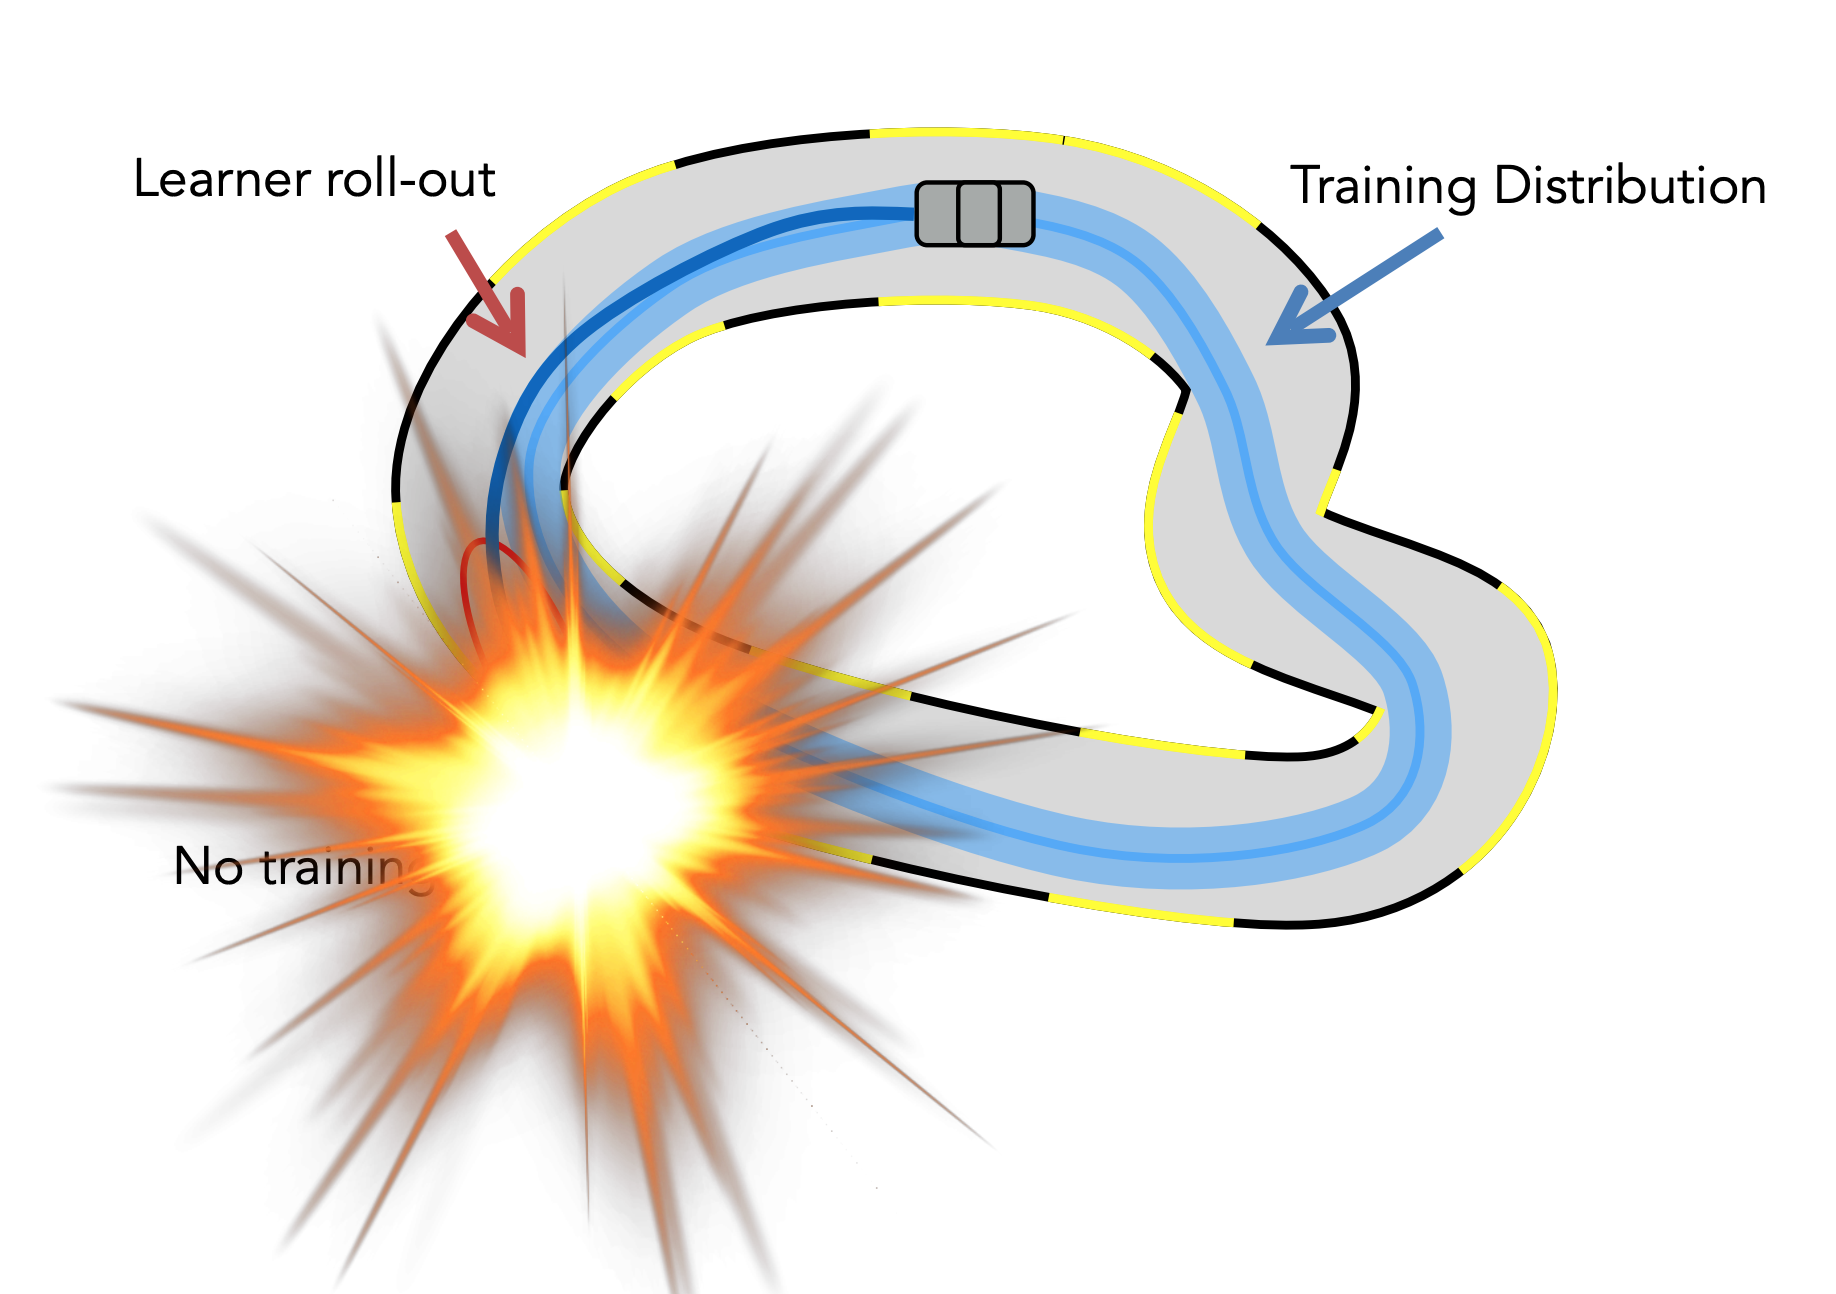


[source](https://www.cc.gatech.edu/~bboots3/ACRL-Spring2019/Lectures/DAgger_slides.pdf)

# Environment

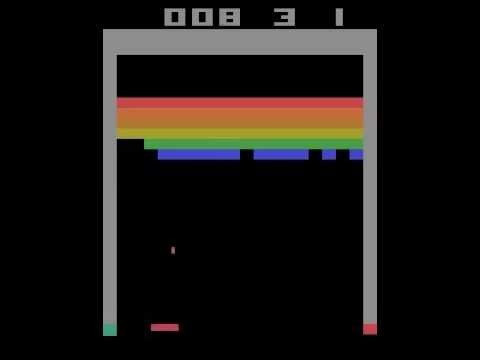

In [ ]:
YouTubeVideo('yQW6TYltcSw')

## Preprocessing

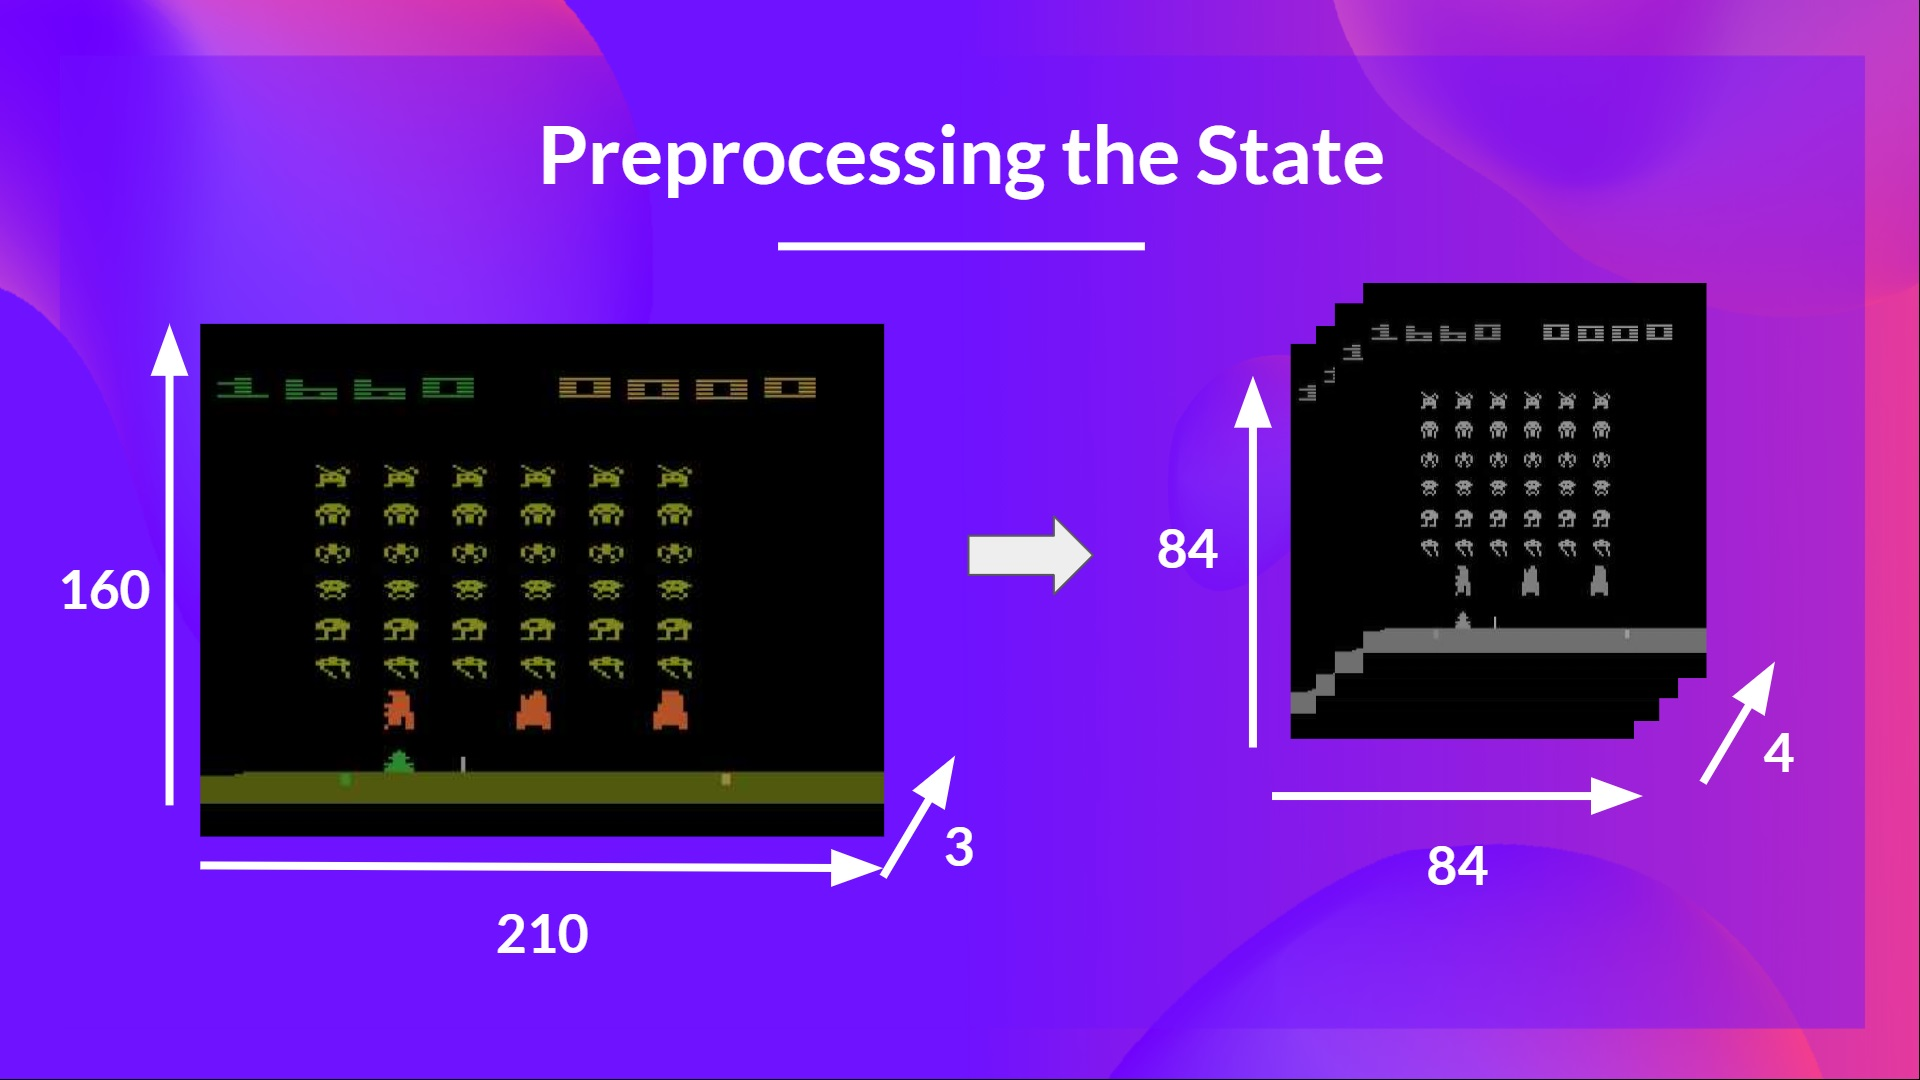

#BASE GYM

In [33]:
# Preprocessors from https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env=None, noop_max=30):
        super(NoopResetEnv, self).__init__(env)
        self.noop_max = noop_max
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self):
        self.env.reset()
        noops = np.random.randint(1, self.noop_max + 1)
        for _ in range(noops):
            obs, _, _, _ = self.env.step(0)
        return obs


class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self):
        self.env.reset()
        obs, _, _, _ = self.env.step(1)
        obs, _, _, _ = self.env.step(2)
        return obs

    
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(EpisodicLifeEnv, self).__init__(env)
        self.lives = 0
        self.was_real_done  = True
        self.was_real_reset = False #False

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        #action = 0
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert somtimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self):
        if self.was_real_done:
            obs = self.env.reset()
            self.was_real_reset = True
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
            self.was_real_reset = False
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip       = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        paso = 0
        for _ in range(self._skip):
            if(paso%2 == 0): action_btn = 0
            else: action_btn = action
            paso = paso +1
            obs, reward, done, info = self.env.step(action_btn)
            #action = 0     # para evitar saltos por acciones repetidas
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)

        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, version=1):
        super().__init__(env)
        self._width = width
        self._height = height
        new_space = gym.spaces.Box(low=0, high=1,
                                   shape=(self._height, self._width, 1),
                                   dtype=np.float32)
        self.observation_space = new_space
        self.ori = new_space      # AGREGADA PARA TENER IMG ORI
        self.done = False

        self.observation = self.observation_v1
        if version == 2:
            self.observation = self.observation_v2
        
    def observation_v1(self, obs):
        frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self._width, self._height), interpolation=cv2.INTER_AREA)
        frame = np.reshape(frame, [84, 84, 1])
        return np.array(frame).astype(np.float32).squeeze()/255.0

    def observation_v2(self, obs):
        #plt.imshow(obs)
        #plt.show()
        #print(obs.shape)
        self.ori = obs.copy()     # COPIA LA IMG ORI
        frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 100),  interpolation=cv2.INTER_LINEAR)
        frame = frame[13:98, :]
        frame = cv2.resize(frame, (self._width, self._height), interpolation=cv2.INTER_AREA)
        frame = np.reshape(frame, [84, 84, 1])
        return np.array(frame).astype(np.float32).squeeze()/255.0

    
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=1, shape=((shp[-1] * k,) + shp[:-1]),
                                            dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        action = 0
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return np.array(self.frames)


def make_env(env_name, version=1):
    env = gym.make(env_name)
    env = EpisodicLifeEnv(env)
    env = NoopResetEnv(env, noop_max=30)
    env = FireResetEnv(env)
    env = MaxAndSkipEnv(env, skip=4)
    env = WarpFrame(env, version=version)
    env = FrameStack(env, 4)
    return env

In [34]:
env = make_env("BreakoutNoFrameskip-v4", version=2)

In [35]:
state = env.reset()

# Model

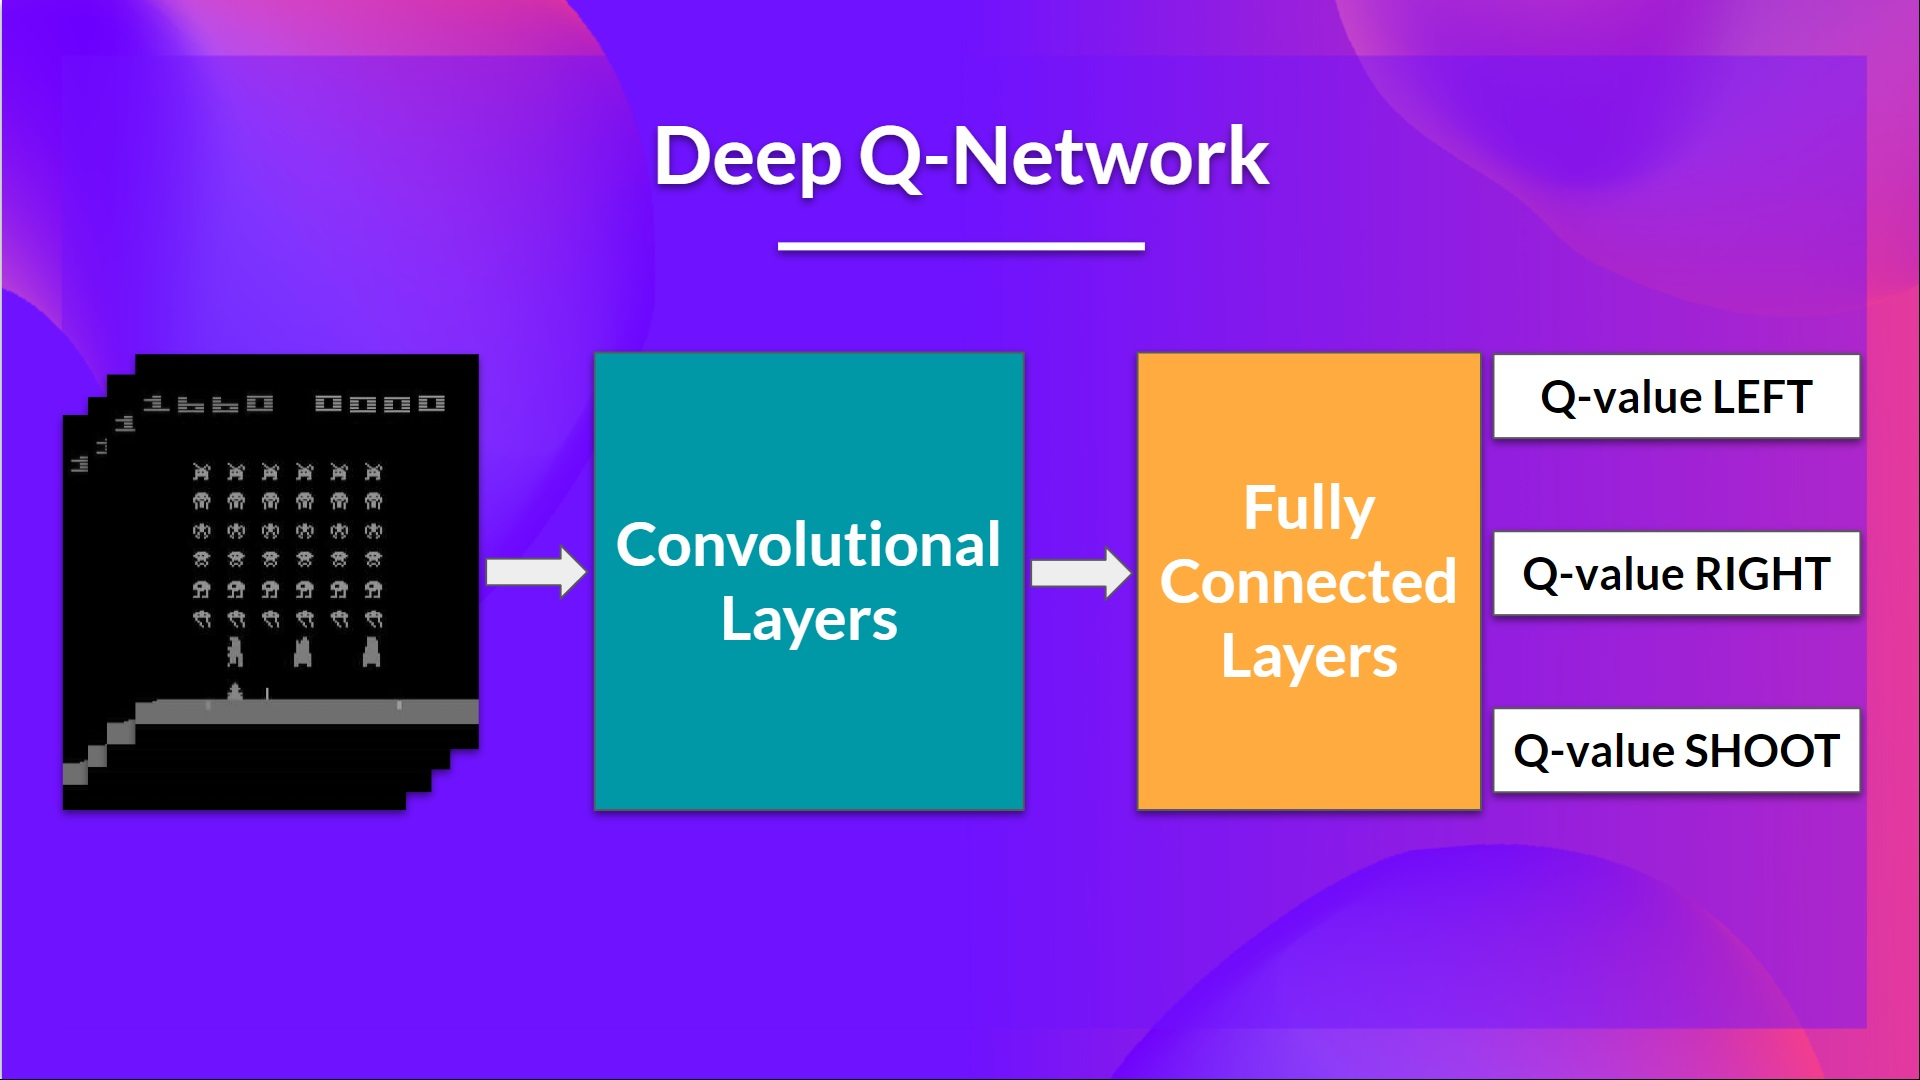

deep-q-network.jpg

In [ ]:
#@title
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        conv_out_size = self.get_conv_out_size(input_shape)
        self.fc1 = nn.Linear(conv_out_size, 512)
        self.fc2 = nn.Linear(512, n_actions)

    def get_conv_out_size(self, shape):
        print(f"conv_out shape:{shape}")
        # conv_out shape:(4, 84, 84)      84x84x4     4 frames de 84x84
        example = self.conv1(torch.zeros(1, shape[0], shape[1], shape[2]))
        example = self.conv2(example)
        example = self.conv3(example)

        print(f"example shape:{example.shape}")
        # example shape:torch.Size([1, 64, 7, 7])

        size = 1
        for x in example.shape:
            size *= x

        print(f"conv_out size:{size}")
        # conv_out size:3136      64x7x7x1    64 caracteristicas de 7x7  x1 color
        return size

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# VERSION 2
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        #self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        #self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        #conv_out_size = self.get_conv_out_size(input_shape)
        # Tensor(5)
        conv_out_size = 6     # las entradas      bola frame1 X1,Y1,  bola frame 4 X2,Y2,   barra frame 4 X3,Y3
        #self.fc1 = nn.Linear(conv_out_size, 6)
        ##self.fc2 = nn.Linear(12, 10)
        #self.fc3 = nn.Linear(6, n_actions)
        self.fc1 = nn.Linear(conv_out_size, n_actions)

    def forward(self, coords_tensor):
        # x = F.relu(self.conv1(x))
        # x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        # x = torch.flatten(x, start_dim=1)
        # x = convolucion_manual(coords_tensor[0].numpy())
        # x = torch.flatten(x, start_dim=1)
        # x = F.relu(self.fc1(coords_tensor))
        #x = F.relu(self.fc1(coords_tensor))
        ##x = F.relu(self.fc2(x))
        #x = self.fc3(x)

        x = self.fc1(coords_tensor)
        return x

In [10]:
#@title
expert_model = DQN(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [ ]:
#@title
expert_model = DQN(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [ ]:
#@title
env.observation_space.shape

(4, 84, 84)

In [ ]:
#@title
env.action_space.n

4

In [ ]:
#@title
state[0]

array([[0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
#@title
tmp = state_tensor.numpy()
tmp

array([[[[0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
          0.5568628],
         [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
          0.5568628],
         [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
          0.5568628],
         ...,
         [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ]],

        [[0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
          0.5568628],
         [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
          0.5568628],
         [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
          0.5568628],
         ...,
         [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         [0.       , 0.       , 0.       , ..., 0.

In [ ]:
#@title
state_tensor[0][0].numpy()

array([[0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
#@title
state_tensor.shape, state.shape, state_tensor[0].numpy().shape

(torch.Size([1, 4, 84, 84]), (4, 84, 84), (4, 84, 84))

In [ ]:
#@title
frame_posicion(state[0], mask_bola) # area bola

(68, 16, 1)

In [ ]:
#@title
frame_posicion(state_tensor[0][0].numpy(), mask_bola) # area bola

(68, 16, 1)

In [ ]:
#@title
state_tensor[0][0]

tensor([[0.5569, 0.5569, 0.5569,  ..., 0.5569, 0.5569, 0.5569],
        [0.5569, 0.5569, 0.5569,  ..., 0.5569, 0.5569, 0.5569],
        [0.5569, 0.5569, 0.5569,  ..., 0.5569, 0.5569, 0.5569],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
#@title
state_tensor = torch.FloatTensor([state]).to(DEVICE)
state_tensor

# Expert

For regular imitation learning it's good enough to have a dataset of expert observations and actions, as we can train a model to clone the behaviour of the expert (*behaviour cloning*) by making it predict the correct action for each state observation.

However, when using DAGGER we need to query the expert about potentially new situations.
Therefore, we need an expert-in-the-loop.
In real life these can be human anotators, but for the purpose of this lab we will use another pre-trained model.

## Downloading expert model

In [ ]:
#@title
!ls -lah *model*

-rw-r--r-- 1 root root 6.5M Jan 25 18:11 RMS-F2__model.model


In [ ]:
#@title
# initialize expert model with pretrained weights
expert_state_dict = torch.load('RMS-F2__model.model', map_location=DEVICE)
expert_model = DQN(env.observation_space.shape, env.action_space.n).to(DEVICE)
expert_model.load_state_dict(expert_state_dict)

<All keys matched successfully>

In [86]:
#@title GRABAR PESOS DEL MODELO
torch.save(student_model.state_dict(), 'EXPERT_model.model')

In [11]:
#@title RECUPERAR PESOS DEL MODELO
# initialize expert model with pretrained weights
expert_state_dict = torch.load('EXPERT_model.model', map_location=DEVICE)
expert_model = DQN(env.observation_space.shape, env.action_space.n).to(DEVICE)
expert_model.load_state_dict(expert_state_dict)

<All keys matched successfully>

In [ ]:
#@title
expert_model = DQN(env.observation_space.shape, env.action_space.n).to(DEVICE)

## CONVOLUCION MANUAL

In [12]:
# REEMPLAZA LA RED CONVOLUCIONAL
def convolucion_manual(state):

    # pasar de Tensor a Numpy Array
    # state = state.numpy()

    # datos de entrada, reemplazan la red convolucional
    Y1, X1, _ = frame_posicion(state[0], mask_bola) # area bola
    Y2, X2, _ = frame_posicion(state[3], mask_bola) # area bola
    Y3, X3, _ = frame_posicion(state[3], mask_barra) # area barra

    # objX es la X4 pero prefiero hacer el paso extra para que sea igual a los anteriores
    #barraX, objX, ancho_barra = posicion_objetivo(state)
    #Y4, X4, _ = frame_posicion(proyeccion(objX), mask_barra) # area proyeccion
    # print(f"X1:{X1}, Y1:{Y1}, X2:{X2}, Y2:{Y2}, X3:{X3}, Y3:{Y3}")

    # normalizar entrada
    x1 = X1/80
    y1 = Y1/80
    x2 = X2/80
    y2 = Y2/80
    x3 = X3/80
    y3 = Y3/80
    #x4 = X4/80
    #y4 = Y4/80

    # se arma el arreglo
    arr = []
    # arr.append(x1, y1, x2, y2, x3, y3) #, y4) # sin proyeccion
    arr.append(x1)
    arr.append(y1)
    arr.append(x2)
    arr.append(y2)
    arr.append(x3)
    arr.append(y3)
 
    arr2 = []
    arr2.append(arr)

    # se pasa a Tensor de 6x1 
    coords_Tensor = torch.FloatTensor(arr2)
    # coords_Tensor = arr.unsqueeze(dim = 0)   # agrega la dim 1

    return coords_Tensor

In [13]:
#convolucion_manual(state)

In [ ]:
#@title
convolucion_manual(state_tensor)

#MODELO APORTADO POR IA GPT

In [ ]:
#@title
#PARA ENTRENAMIENTO REFORZADO
import numpy as np

# definir la matriz de transición de estado-acción
P = np.array([[[0.5, 0.5], [0, 1]], [[1, 0], [0.8, 0.2]]])

# definir la matriz de recompensa
R = np.array([[10, -50], [-1, 10]])

# definir los parámetros del algoritmo
gamma = 0.9  # tasa de descuento
epsilon = 0.1  # tolerancia para la convergencia

# inicializar la función de valor
V = np.zeros(2)

# iterar hasta convergencia
while True:
    V_prev = np.copy(V)
    for s in range(2):
        Q = np.zeros(2)
        for a in range(2):
            for s_prime in range(2):
                Q[a] += P[s][a][s_prime] * (R[s][s_prime] + gamma * V[s_prime])
        V[s] = np.max(Q)
    if np.max(np.abs(V - V_prev)) < epsilon:
        break

# imprimir la función de valor final
print(V)

In [ ]:
#@title
#para ciclo de acciones estado
import gym
import pygame

# Crear un ambiente de Pygame
env = gym.make("Breakout-v0")

# Inicializar variables
done = False
total_reward = 0

# Inicializar el estado
s = env.reset()

# Bucle de juego
while not done:
    # Escoger una acción
    a = agent.choose_action(s)

    # Realizar la acción en el ambiente
    s_prime, reward, done, info = env.step(a)

    # Actualizar el agente
    agent.update(s, a, reward, s_prime)

    # Actualizar el estado
    s = s_prime

    # Actualizar la recompensa total
    total_reward += reward

    # Dibujar el juego en la pantalla
    env.render()

# Finalizar el juego
env.close()

print("Recompensa total: ", total_reward)


In [ ]:
#@title
#para grabar estado anterior y repetirlo con otra accion
import copy

# Obtener el estado actual del ambiente
state = env.get_state()

# Crear una copia del estado actual
state_copy = copy.deepcopy(state)
#estado_copia = copy.copy(estado)

# Dar un paso adicional en la copia del estado
next_state, reward, done, info = env.step(state_copy, action)



## Querying expert

In [13]:
def get_action_from_policy(model, states):
    """
    Model chooses best action for each state using learned policy.

    INPUT:
        model: torch model
        states: torch.Tensor(shape={batch_size, *(state_shape)})
    
    OUTPUT:
        torch.Tensor(shape={batch_size}) index of the best action under policy.
    """

    _, best_action = torch.max(model(states), dim=1)
    return best_action

In [ ]:
#@title
state.shape

(4, 84, 84)

In [ ]:
#@title
#VERSION 2 sin    dim 1
def _get_action_from_policy(model, states):
    """
    Model chooses best action for each state using learned policy.

    INPUT:
        model: torch model
        states: torch.Tensor(shape={batch_size, *(state_shape)})
    
    OUTPUT:
        torch.Tensor(shape={batch_size}) index of the best action under policy.
    """

    _, best_action = torch.max(model(states), dim=0)
    return best_action

In [ ]:
#@title
# test query function
state = env.reset()
state_tensor = torch.FloatTensor([state]).to(DEVICE)

In [ ]:
#@title
CV = convolucion_manual(state_tensor[0].numpy())
print(CV)
expert_action = expert_model(state_tensor)
print(expert_action)

tensor([0.6625, 0.6750, 0.6625, 0.6750, 0.2375, 0.9625])
tensor([0.3186, 0.2659, 0.1519, 0.1381], grad_fn=<AddBackward0>)


In [ ]:
#@title
torch.max(expert_action, dim=0)

torch.return_types.max(
values=tensor(0.2657, grad_fn=<MaxBackward0>),
indices=tensor(1))

In [ ]:
#@title
expert_action = expert_model(state_tensor)
expert_action

tensor([0.3186, 0.2659, 0.1519, 0.1381], grad_fn=<AddBackward0>)

In [ ]:
#@title
torch.max(expert_action, dim=1)

torch.return_types.max(
values=tensor(0.3186, grad_fn=<MaxBackward0>),
indices=tensor(0))

In [ ]:
#@title
# test query function
state = env.reset()
state_tensor = torch.FloatTensor([state]).to(DEVICE)
expert_action = get_action_from_policy(expert_model, state_tensor)
expert_action.item()

3

In [ ]:
#@title
# test query function
state = env.reset()
state_tensor = torch.FloatTensor([state])
expert_action = get_action_from_policy(expert_model, state_tensor)
expert_action

tensor([0])

(210, 160, 3)

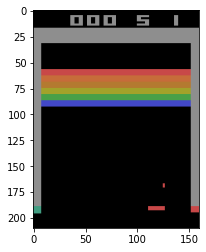

In [ ]:
#@title
plt.imshow(env.ori)
env.ori.shape

(210, 160, 3)


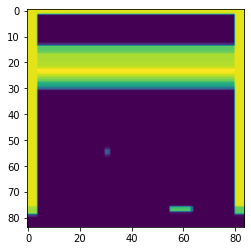

In [ ]:
#@title
state = env.reset()
plt.imshow(state[3])

In [ ]:
#@title
#/usr/local/lib/python3.8/dist-packages/gym/core.py

env.ori.shape, env.ori

((210, 160, 3), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8))

In [ ]:
#@title
#para grabar estado anterior y repetirlo con otra accion
import copy
import pickle
    
state_orig = env.reset()
state = copy.deepcopy(state_orig)
plt.imshow(state[3])

# Guardar arreglo en disco
#with open("env.pickle", "wb") as f:
#    pickle.dump(env, f)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(30,10)
state = copy.deepcopy(state_orig)

#env_copy = copy.copy(env)
# Recuperar arreglo desde disco
#with open("env.pickle", "rb") as f:
#    env_copy = pickle.load(f)
expert_action = 3
state = copy.deepcopy(state_orig)
state, puntos, is_done, *(_) = env.step(int(expert_action))
#state, _, _, _ = env.step(state_copy, int(expert_action))
ax[0].imshow(state[3])
#plt.show()

#env_copy = copy.copy(env)
# Recuperar arreglo desde disco
#with open("env.pickle", "rb") as f:
#    env_copy = pickle.load(f)
#env_copy = copy.copy(env)
expert_action = 0
state, puntos, is_done, *(_) = env.step(int(expert_action))
#state, *(_) = env.step(state_copy, int(expert_action))
ax[1].imshow(state[3])
#plt.show()

#env_copy = copy.copy(env)
# Recuperar arreglo desde disco
#with open("env.pickle", "rb") as f:
#    env_copy = pickle.load(f)
#env_copy = copy.copy(env)
expert_action = 2
state = copy.deepcopy(state_orig)
state, puntos, is_done, *(_) = env.step(int(expert_action))
#state, *(_) = env.step(state_copy, int(expert_action))
ax[2].imshow(state[3])
plt.show()


#MEMORIA

- https://rico-schmidt.name/pymotw-3/sys/limits.html
- https://pymotw.com/3/

La implementación principal de Python (CPython) usa recuento de referencias y recolección de basura para la administración automática de memoria. Un objeto se marca automáticamente para ser recolectado cuando su recuento de referencia cae a cero. Para examinar el recuento de referencia de un objeto existente, usa getrefcount().

El valor informado es en realidad uno más alto de lo esperado porque hay una referencia temporal al objeto contenido por getrefcount().




In [ ]:
#@title
import sys

one = []
print('At start         :', sys.getrefcount(one))

two = one

print('Second reference :', sys.getrefcount(one))

del two

print('After del        :', sys.getrefcount(one))


At start         : 2
Second reference : 3
After del        : 2


gc – Control the garbage collector via the functions exposed in gc.


Saber cuántas referencias tiene un objeto puede ayudar a encontrar ciclos o una pérdida de memoria, pero no es suficiente para determinar qué objetos están consumiendo la mayoría de la memoria. Eso requiere conocimiento sobre cuán grandes son los objetos.

getsizeof() informa el tamaño de un objeto en bytes.

El tamaño informado para una clase personalizada no incluye el tamaño de los valores de los atributos.

Esto puede dar una falsa impresión de la cantidad de memoria que se consume.


In [ ]:
#@title
import sys


class MyClass:
    pass


objects = [
    [], (), {}, 'c', 'string', b'bytes', 1, 2.3,
    MyClass, MyClass(),
]

for obj in objects:
    print('{:>10} : {}'.format(type(obj).__name__,
                               sys.getsizeof(obj)))


      list : 56
     tuple : 40
      dict : 64
       str : 50
       str : 55
     bytes : 38
       int : 28
     float : 24
      type : 1064
   MyClass : 48


Para una estimación más completa del espacio utilizado por una clase, proporciona un método __sizeof__() para calcular el valor agregando los tamaños de los atributos de un objeto.

In [ ]:
#@title
import sys


class WithoutAttributes:
    pass


class WithAttributes:
    def __init__(self):
        self.a = 'a'
        self.b = 'b'
        return


without_attrs = WithoutAttributes()
print('WithoutAttributes:', sys.getsizeof(without_attrs))

with_attrs = WithAttributes()
print('WithAttributes:', sys.getsizeof(with_attrs))


WithoutAttributes: 48
WithAttributes: 48


Esta versión agrega el tamaño base del objeto a los tamaños de todos los atributos almacenados en el __dict__ interno.

In [ ]:
#@title
import sys


class WithAttributes:
    def __init__(self):
        self.a = 'a'
        self.b = 'b'
        return

    def __sizeof__(self):
        return object.__sizeof__(self) + \
            sum(sys.getsizeof(v) for v in self.__dict__.values())


my_inst = WithAttributes()
print(sys.getsizeof(my_inst))


148


In [ ]:
#@title
import resource
import time

RESOURCES = [
    ('ru_utime', 'User time'),
    ('ru_stime', 'System time'),
    ('ru_maxrss', 'Max. Resident Set Size'),
    ('ru_ixrss', 'Shared Memory Size'),
    ('ru_idrss', 'Unshared Memory Size'),
    ('ru_isrss', 'Stack Size'),
    ('ru_inblock', 'Block inputs'),
    ('ru_oublock', 'Block outputs'),
]

usage = resource.getrusage(resource.RUSAGE_SELF)

for name, desc in RESOURCES:
    print('{:<25} ({:<10}) = {}'.format(
        desc, name, getattr(usage, name)))


User time                 (ru_utime  ) = 8.55517
System time               (ru_stime  ) = 1.534611
Max. Resident Set Size    (ru_maxrss ) = 408564
Shared Memory Size        (ru_ixrss  ) = 0
Unshared Memory Size      (ru_idrss  ) = 0
Stack Size                (ru_isrss  ) = 0
Block inputs              (ru_inblock) = 465128
Block outputs             (ru_oublock) = 104840


In [ ]:
#@title
!df

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        112947452 24781164  88149904  22% /
tmpfs              65536        0     65536   0% /dev
shm              5989376        0   5989376   0% /dev/shm
/dev/root        2003760  1142612    861148  58% /usr/sbin/docker-init
tmpfs            6648600       36   6648564   1% /var/colab
/dev/sda1       73032084 50137824  22877876  69% /etc/hosts
tmpfs            6648600        0   6648600   0% /proc/acpi
tmpfs            6648600        0   6648600   0% /proc/scsi
tmpfs            6648600        0   6648600   0% /sys/firmware


In [ ]:
#@title
env._width

In [ ]:
#@title
print(expert_action[0].numpy())

3


In [ ]:
#@title
res = expert_model(state_tensor)

In [ ]:
#@title
res

tensor([[15.3232, 15.7672, 15.5992, 16.2323]], grad_fn=<AddmmBackward0>)

In [ ]:
#@title
torch.max(res), "////",  torch.max(res, dim=1)

(tensor(16.2323, grad_fn=<MaxBackward1>), '////', torch.return_types.max(
 values=tensor([16.2323], grad_fn=<MaxBackward0>),
 indices=tensor([3])))

In [ ]:
#@title
_, indice = torch.max(res, dim=1)
num = indice[0].numpy()
nim = f"{indice[:]}"
np.abs(indice[0].numpy())

3

In [ ]:
#@title
env.observation_v2

<bound method WarpFrame.observation_v2 of <WarpFrame<MaxAndSkipEnv<FireResetEnv<NoopResetEnv<EpisodicLifeEnv<TimeLimit<AtariEnv<BreakoutNoFrameskip-v4>>>>>>>>>

In [ ]:
#@title
state = env.reset()
state_tensor = torch.FloatTensor([state]).to(DEVICE)
actions = expert_model(state_tensor)
actions

In [ ]:
#@title
state.shape

(4, 84, 84)

In [ ]:
#@title
state_tensor.shape

torch.Size([1, 4, 84, 84])

In [ ]:
#@title
state[0].shape

(84, 84)

In [ ]:
#@title
state[0]

array([[0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

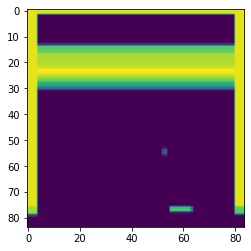

In [ ]:
#@title
#image = cv2.cvtColor(state[0], cv2.COLOR_BGR2RGB)
plt.imshow(state[0])
#plt.show()

In [ ]:
#@title
plt.imshow(state[0])

## LIBRERIA PARA VIDEO

In [14]:
# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media

Installing mediapy:


In [ ]:
#@title
# More legible printing from numpy.
#np.set_printoptions(precision=3, suppress=True, linewidth=100)

#MAPAS DE IMAGENES

In [ ]:
#@title
mapnum = [
   
 0,1,1,0
,1,0,0,1
,1,0,0,1
,1,0,0,1
,0,1,1,0

,0,1,0,0
,1,1,0,0
,0,1,0,0
,0,1,0,0
,1,1,1,0

,0,1,1,1
,1,0,0,1
,0,0,1,0
,0,1,0,0
,1,1,1,1

,1,1,1,0
,0,0,0,1
,0,1,1,0
,0,0,0,1
,1,1,1,0

,0,0,1,0
,0,1,1,0
,1,1,1,1
,0,0,1,0
,0,0,1,0

,1,1,1,1
,1,0,0,0
,0,1,1,0
,0,0,0,1
,1,1,1,0

,0,0,1,0
,0,1,0,0
,1,0,1,0
,1,0,0,1
,0,1,1,0

,1,1,1,1
,0,0,1,0
,0,1,0,0
,0,1,0,0
,0,1,0,0

,0,1,1,0
,1,0,0,1
,0,1,1,0
,1,0,0,1
,0,1,1,0

,0,1,1,0
,1,0,0,1
,0,1,1,0
,0,0,1,0
,0,1,0,0
]

In [ ]:
#@title
map = [
   
 1,1,1,1
,1,0,0,1
,1,0,0,1
,1,0,0,1
,1,1,1,1

,0,1,0,0
,1,1,0,0
,0,1,0,0
,0,1,0,0
,1,1,1,0

,1,1,1,0
,0,0,0,1
,0,0,1,0
,0,1,0,0
,1,1,1,1

,1,1,1,1
,0,0,0,1
,0,1,1,1
,0,0,0,1
,1,1,1,1

,0,1,0,0
,0,1,0,0
,1,1,1,1
,0,0,1,0
,0,0,1,0
]
          #0 nada
          #1 fire
          #2 izq
          #3 der

bot = [
   
 1,1,1,1
,1,0,0,1
,1,0,0,1
,1,0,0,1
,1,1,1,1

,0,1,0,0
,1,1,0,0
,0,1,0,0
,0,1,0,0
,1,1,1,0

,0,1,0,0
,0,0,1,0
,1,1,1,1
,0,0,1,0
,0,1,0,0

,0,0,1,0
,0,1,0,0
,1,1,1,1
,0,1,0,0
,0,0,1,0

,0,1,0,0
,0,1,0,0
,1,1,1,1
,0,0,1,0
,0,0,1,0

,1,1,0,0
,1,1,0,0
,0,0,0,0
,0,0,0,0
,0,0,0,0

]

In [ ]:
#@title
def dib_car(frames, car, xPos, yPos, usemap=bot):
  if(0):
    #if(car<0 or car>5): car=0
    anchoCar = 4
    altoCar = 5
    lineaCar = 0
    posCar = car*(altoCar*anchoCar) # + lineaCar*anchoCar
    while(lineaCar < altoCar):
        #frames[len(frames)-1][yPos+lineaCar][xPos:xPos+anchoCar] = map[posCar:posCar+anchoCar]
        frames[yPos+lineaCar][xPos:xPos+anchoCar] = usemap[posCar:posCar+anchoCar]
        lineaCar = lineaCar + 1
        posCar = posCar + anchoCar #car*altoCar + lineaCar*anchoCar
    return frames
  return frames

In [14]:
# YA NO SE USA
def frames_accion(state, Y, lineas=1):
  # el ultimo (3) frame es el ultimo en ocurrir 
  # el primer (0) frame es el mas antiguo en el tiempo
  frame_i = 0
  linea_y_barra = Y #76
  frames_obj1 = [] #anterior
  frames_obj2 = [] #ultimo

  #frames_obj1.append(state[frame_i].copy())
  #frames_obj1.append(state[frame_i][linea_y_barra:linea_y_barra+lineas].copy())
  frames_obj1.append(state[frame_i+1][linea_y_barra:linea_y_barra+lineas][:])
  frames_obj2.append(state[frame_i+3][linea_y_barra:linea_y_barra+lineas][:])
  #return frames_obj1, frames_obj2
  return state[frame_i+1][linea_y_barra:linea_y_barra+lineas].copy(), state[frame_i+3][linea_y_barra:linea_y_barra+lineas].copy()

In [17]:
# YA NO SE USA
def frames_reward(state, Y=74, YY=76, lineas=1):
  # el ultimo (3) frame es el ultimo en ocurrir 
  # el primer (0) frame es el mas antiguo en el tiempo
  frame_i = 0
  linea_y_bola = Y #74
  linea_y_barra = YY #76
  frames_obj1 = [] #anterior
  frames_obj2 = [] #ultimo
  left = 4
  right = 4
  reward=0

  #frames_obj1.append(state[frame_i].copy())
  #frames_obj1.append(state[frame_i][linea_y_barra:linea_y_barra+lineas].copy())

  #obj1: barra
  frames_obj1.append(state[frame_i+3][linea_y_bola:linea_y_bola+lineas][0][left:84-right])
  #obj1: bola
  frames_obj2.append(state[frame_i+3][linea_y_barra:linea_y_barra+lineas][0][left:84-right])

  #plt.imshow(frames_obj2)
  #plt.show()
  #plt.imshow(frames_obj1)
  #plt.show()


  #en que columna esta la bola
  #posX = max(frames_obj2, dim=1)
  #posX = frames_obj2.index(max(frames_obj2))
  posX = np.argmax(frames_obj2)
  if(frames_obj2[0][posX]==0):
    posX = -1
  #print("posX: ", posX)
  #torch.max(res), "////",  torch.max(res, dim=1)

  #si en esa columna esta la barra
  if(posX >= 0 and frames_obj1[0][posX]>0): 
    reward=1
    #print("posX: ", posX)
    #print("obj2: ", frames_obj2[0])
    #print("obj1: ", frames_obj1[0])
    #print("reward: ", reward)

  return reward #, posX, frames_obj1, frames_obj2
  #return state[frame_i+1][linea_y_barra:linea_y_barra+lineas].copy(), state[frame_i+3][linea_y_barra:linea_y_barra+lineas].copy()

In [ ]:
#@title
# Create a 2D Numpy array from list of lists
arr2D =    np.array([[11, 12, 13],
                     [14, 15, 16],
                     [17, 15, 11],
                     [12, 14, 15]])

In [ ]:
#@title
# Get the maximum values of each column i.e. along axis 0
maxInColumns = np.amax(arr2D, axis=0)
print('Max value of every column: ', maxInColumns)


Max value of every column:  [17 15 16]


In [ ]:
#@title
# Get the maximum values of each row i.e. along axis 1
maxInRows = np.amax(arr2D, axis=1)
print('Max value of every Row: ', maxInRows)


Max value of every Row:  [13 16 17 15]


In [ ]:
#@title
# Find index of maximum value from 2D numpy array
result = np.where(arr2D == np.amax(arr2D))
print('Tuple of arrays returned : ', result)
print('List of coordinates of maximum value in Numpy array : ')
# zip the 2 arrays to get the exact coordinates
listOfCordinates = list(zip(result[0], result[1]))
# travese over the list of cordinates
for cord in listOfCordinates:
    print(cord)
result, int(result[0]), int(result[1])

Tuple of arrays returned :  (array([2]), array([0]))
List of coordinates of maximum value in Numpy array : 
(2, 0)


((array([2]), array([0])), 2, 0)

#FRAME POSICION

In [ ]:
#@title
def frames_posicion__(frames, y1=0, y2=84, x1=0, x2=84):
  arr2D = frames[3][y1:y2][x1:x2]  #frames[3][y1:y2][:][x1:x2]
  print(arr2D)
  result = np.where(arr2D == np.amax(arr2D))
  print(int(result[0]), int(result[1]))
  return 1#int(result[0]), int(result[1])

In [15]:
#previamente hay que definir la mask
def frame_posicion(frame, mask): # , y1=0, y2=84, x1=0, x2=84):
  #frame = frame.numpy()
  arr2D = frame * mask
  #print(arr2D)
  result = np.where(arr2D == np.amax(arr2D))
  #print(int(result[0][0]), int(result[1][0]))
  return int(result[0][0]), int(result[1][0]), len(result[0])  # posicionY, posicionX y cantidad

In [ ]:
#@title
state.dtype, state.ndim, state.shape, len(state)

(dtype('float32'), 3, (4, 84, 84), 4)

In [ ]:
#@title
#plano pasa el area a solo 0 o 1
import numpy.ma as ma
plano = state[3].copy()
for i in range(84):
  for j in range(84):
    if(plano[i][j] >0): 
      plano[i][j] = 1
    else:
      plano[i][j] = 0

## MASCARAS

In [16]:
# CONVIERTE A 0 y 1 REDUCIENDO LOS CALCULOS
import numpy.ma as ma
def frame_plano(frame):
 plano = frame.copy()
 for i in range(84):
   for j in range(84):
     if(plano[i][j] >0): 
       plano[i][j] = 1
     else:
       plano[i][j] = 0
 return plano

In [17]:
#mask mascara de area bola
import numpy.ma as ma
mask_bola = state[3].copy()
for i in range(84):
  for j in range(84):
     if(i>32 and i<76 and j>4 and j<79):
        mask_bola[i][j] = 1
     else: 
        mask_bola[i][j] = 0

In [18]:
#mask mascara de area barra
import numpy.ma as ma
mask_barra = state[3].copy()
for i in range(84):
  for j in range(84):
     if(i==77 and j>4 and j<80):
        mask_barra[i][j] = 1
     else: 
        mask_barra[i][j] = 0

In [19]:
#mask mascara de area zero
import numpy.ma as ma
mask_zero = state[3].copy()
for i in range(84):
  for j in range(84):
     #if(i>32 and i<76 and j>4 and j<79):
     #   mask_bola[i][j] = 1
     #else: 
        mask_zero[i][j] = 0

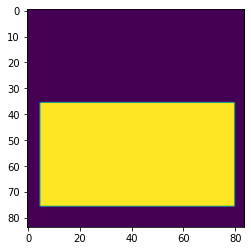

In [ ]:
#@title
#mask
plt.imshow(mask_bola)

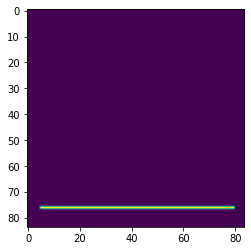

In [ ]:
#@title
plt.imshow(mask_barra)

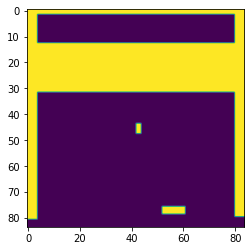

In [ ]:
#@title
plt.imshow(plano)

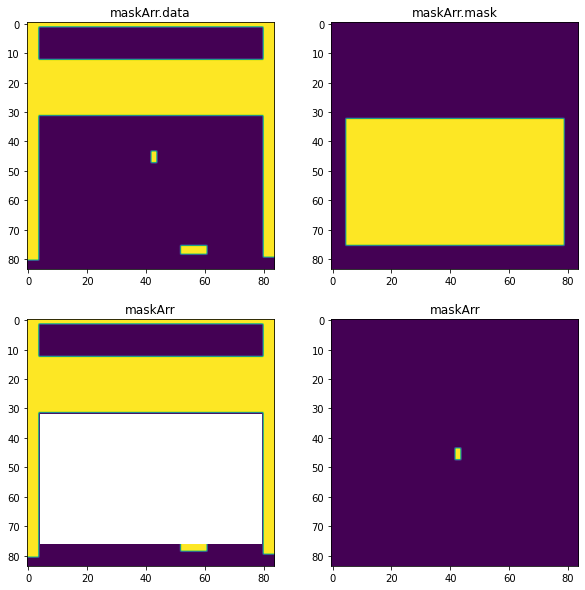

In [ ]:
#@title
maskArr = ma.masked_array(plano, mask_bola.__eq__(1))
#maskArr.data
#print(maskArr)
#plt.imshow(maskArr.mask)
#plt.show()
#plt.imshow(maskArr.data)
#plt.show()
#plt.imshow(maskArr)
#plt.show()

#plt.figsize=(100,80)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax[0,0].set_title('maskArr.data')
ax[0,0].imshow(maskArr.data)
ax[0,1].set_title('maskArr.mask')
ax[0,1].imshow(maskArr.mask)
ax[1,0].set_title('maskArr')
ax[1,0].imshow(maskArr)
ax[1,1].set_title('maskArr')
ax[1,1].imshow(plano*mask_bola)


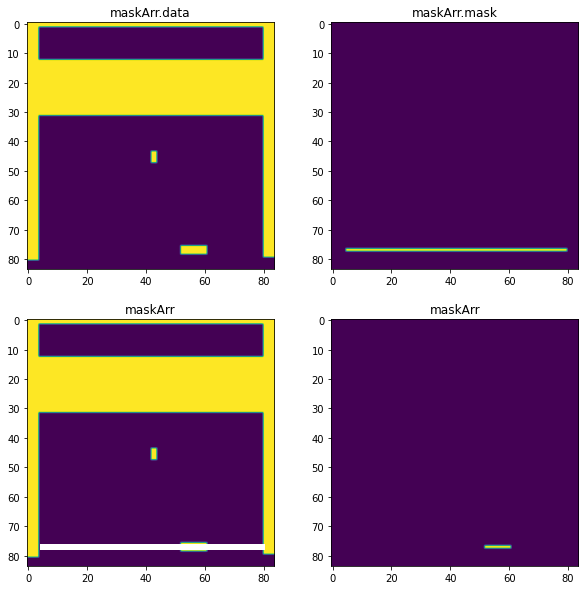

In [ ]:
#@title
maskArr = ma.masked_array(plano, mask_barra.__eq__(1))
#maskArr.data
#print(maskArr)
#plt.imshow(maskArr.mask)
#plt.show()
#plt.imshow(maskArr.data)
#plt.show()
#plt.imshow(maskArr)
#plt.show()

#plt.figsize=(100,80)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax[0,0].set_title('maskArr.data')
ax[0,0].imshow(maskArr.data)
ax[0,1].set_title('maskArr.mask')
ax[0,1].imshow(maskArr.mask)
ax[1,0].set_title('maskArr')
ax[1,0].imshow(maskArr)
ax[1,1].set_title('maskArr')
ax[1,1].imshow(plano*mask_barra)

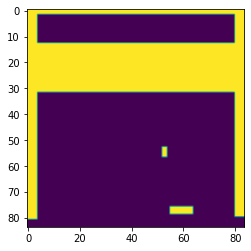

In [ ]:
#@title
plt.imshow(plano.__eq__(1))

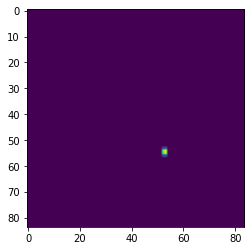

In [ ]:
#@title
res = state[3] * mask_bola
plt.imshow(res)


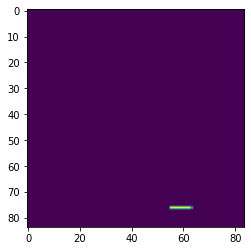

In [ ]:
#@title
res = state[3] * mask_barra
plt.imshow(res)

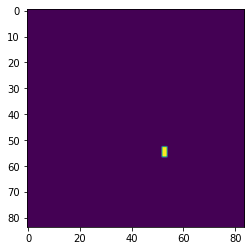

In [ ]:
#@title
plt.imshow(frame_plano(state[3]) * mask_bola)

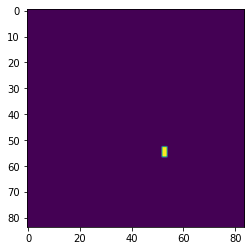

In [ ]:
#@title
plt.imshow(frame_plano(state[3] * mask_bola))

In [ ]:
#@title
result = np.where(res == np.amax(res))
int(result[0][0]), (result[1][0])

(54, 53)

In [ ]:
#@title
result

(array([54]), array([53]))

In [ ]:
#@title
maskArr.data.dtype, maskArr.data.ndim, maskArr.data.shape, len(maskArr.data)

(dtype('float32'), 2, (84, 84), 84)

In [ ]:
#@title
np.ma.mask_rowcols(maskArr)

masked_array(
  data=[[0.5568627715110779, 0.5568627715110779, 0.5568627715110779, ...,
         0.5568627715110779, 0.5568627715110779, 0.5568627715110779],
        [0.5568627715110779, 0.5568627715110779, 0.5568627715110779, ...,
         0.5568627715110779, 0.5568627715110779, 0.5568627715110779],
        [0.5568627715110779, 0.5568627715110779, 0.5568627715110779, ...,
         0.5568627715110779, 0.5568627715110779, 0.5568627715110779],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

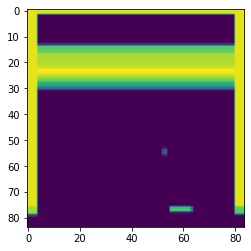

In [ ]:
#@title
plt.imshow(state[3])

In [ ]:
#@title
maxInRows = np.amax(maskArr.data, axis=1)
maxInRows

array([0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5803922 , 0.5686275 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 ,
       0.5568628 , 0.5568628 , 0.5568628 , 0.5568628 , 0.55686

In [ ]:
#@title
#fila maxima
result = np.where(maskArr.data == np.amax(maskArr.data))
result
#print(int(result[0]), int(result[1]))

(array([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79]))

In [ ]:
#@title
# Get the maximum values of each column i.e. along axis 0
maxInColumns = np.amax(maskArr.data, axis=0)
maxInColumns

array([0.5568628, 0.5568628, 0.5568628, 0.5568628, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922, 0.5803922,
       0.5803922, 0.5803922, 0.5568628, 0.5568628, 

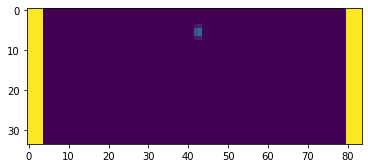

In [ ]:
#@title
plt.imshow(state[3][35:74][:][5:80])

In [ ]:
#@title
state[3][35:74][10:11][0][5:80].shape

(75,)

In [ ]:
#@title
print(state[3][35:74][10:11][0][5:80])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.13725491 0.19607843 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [ ]:
#@title
state[3][35:73][:][0:84]

array([[0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       ...,
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628],
       [0.5568628, 0.5568628, 0.5568628, ..., 0.5568628, 0.5568628,
        0.5568628]], dtype=float32)

In [ ]:
#@title
frames_posicion(state, 35, 73, 5, 80 )

In [ ]:
#@title
state.shape

(4, 84, 84)

In [ ]:
#@title
state[3][1:7][1:2].shape

(1, 84)

In [ ]:
#@title
state[3][1:1][1:2]

array([], shape=(0, 84), dtype=float32)

In [ ]:
#@title
np.argmax(state[3][76:77][0][4:80])

39

In [ ]:
#@title
print(state[3][76:77][0][1:10])

[0.5019608 0.5019608 0.5019608 0.        0.        0.        0.
 0.        0.       ]


In [ ]:
#@title
frames_obj = []
frames_obj.append(state[3][76:77][0][5:80])
posX= np.argmax(state[3][76:77][0][4:80])
posX, frames_obj

(36, [array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.39215687, 0.39215687, 0.39215687, 0.39215687, 0.39215687,
         0.39215687, 0.39215687, 0.39215687, 0.39215687, 0.39215687,
         0.12156863, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.       

In [ ]:
#@title
frames_obj[0][posX] > 0

True

In [ ]:
#@title
def best_acction_old(posX1, posX2):
  # ACCION SEGUN POSICION EN FRAME
  #0 nada
  #1 fire
  #2 der
  #3 izq
  ancho_barra = 7  #ancho/2
  ancho_bola = 0
  acc = 0

  #   +               pe+ap < ba      => <-
  #        ________
  #1234 5678
  if(posX1+ancho_bola < posX2): acc=3  # izq

  #    +              pe < ba & pe+ap = ba    => <-
  #     ________
  #1234 678
  #if(posX1+ancho_bola < posX2): acc=1  # izq

  #       +           pe+ap < ba+ab & pe > ba     => 0
  #    ________
  #1234 678
  if(posX1+ancho_bola < posX2+ancho_barra and posX1 > posX2): acc=0  # none

  #            +      pe >= ba+ab     => ->
  #    ________
  #12345 6789012
  if(posX1 > posX2+ancho_barra): acc=2  # der

  #               +   pe > ba+ab      => ->
  #   ________
  #123456789012345

  #if(posX2+3 < posX1+0): acc=2  # der
  #if(posX2+0 > posX1+0): acc=3  # izq
  if(posX1 == 0): acc=0
  #print(f'bola:{posX1} barra:{posX2} acc:{acc}')
  return acc

In [ ]:
#@title
objetivo  = 0

#POSICION OBJETIVO

In [20]:
def posicion_objetivo(frames):
  ancho_barra = 7

  # POSICION EN FRAME
  bolaY1, bolaX1, _ = frame_posicion(frames[0], mask_bola) # area bola
  bolaY2, bolaX2, ancho_bola = frame_posicion(frames[3], mask_bola) # area bola
  barraY, barraX, ancho_barra = frame_posicion(frames[3], mask_barra) # area barra

  barraY = 76
  #barraY = barraY-1
  proyectar = (84/2)-ancho_barra/2 # centro pantalla
  if(bolaY2 > bolaY1): # baja la bola
   proyectar = bolaY2
   if(bolaX2 != bolaX1):
    # CALCULA LA PENDIENTE Y PROYECTA DONDE GOLPEARA
    m=0.01
    if(bolaX2 != bolaX1): m = (bolaY2 - bolaY1) / (bolaX2 - bolaX1)
    b = bolaY1 - bolaX1 * m
    proyectar = (barraY - b) / m
    #proyectar = (barraY -(bolaY1 - bolaX1*((bolaY2 - bolaY1) / (bolaX2 - bolaX1)))) / ((bolaY2 - bolaY1) / (bolaX2 - bolaX1))

  # SI PASA MAS ALLA DE LA PARED IZQ
  paredA = 4
  if(proyectar <= paredA):
    ##reflejo = paredA - proyectar
    #proyectar = paredA - proyectar + paredA
    proyectar = 2*paredA - proyectar

  # SI PASA MAS ALLA DE LA PARED DER
  paredB = 80
  if(proyectar >= paredB):
    #reflejo = paredB - proyectar
    #proyectar = paredB + reflejo
    proyectar = 2*paredB - proyectar

  # ACCION DISTINTA AL SUBIR O ESTAR FUERA DEL AREA DE VISION INMEDIATA
  if(bolaY2 < bolaY1 or bolaY2 < 45): # sube la bola o sobre linea 50 solo sigue la bola
    proyectar = bolaX2

  # SOLO PARA PONER LIMITE
  if(proyectar >= paredB):
    proyectar = paredB

  if(proyectar <= paredA):
    proyectar = paredA

  #return int(barraY), int(proyectar), (bolaY2 > bolaY1) # Y, X, baja la bola=1
  return int(barraX), int(proyectar), (bolaY2 > bolaY1) # barraX, objX, baja la bola=1

In [ ]:
#@title
def ____posicion_objetivo(frames):
  ancho_barra = 7

  # POSICION EN FRAME
  bolaY1, bolaX1, _ = frame_posicion(frames[0], mask_bola) # area bola
  bolaY2, bolaX2, ancho_bola = frame_posicion(frames[3], mask_bola) # area bola
  barraY, barraX, ancho_barra = frame_posicion(frames[3], mask_barra) # area barra

  barraY = 76
  #barraY = barraY-1
  proyectar = (84/2)-ancho_barra/2 # centro pantalla
  if(bolaY2 >= bolaY1): # baja la bola
    proyectar = bolaX2  # parte considerando que estan en la misma posicion sera mov vertical
    m=0.01 # inicializa
    if(bolaX2 != bolaX1):
      if(bolaX2 != bolaX1): m = (bolaY2 - bolaY1) / (bolaX2 - bolaX1)
      # m = (bolaY2 - bolaY1) / (bolaX2 - bolaX1)
      if(m == 0): m = 0.01
      b = bolaY1 - bolaX1 * m
      proyectar = (barraY - b) / m

      # RESUMIDA    X3 = (Y3 - Y1) /m + X1
      # proyectar = (barraY - bolaY2) / m + bolaX2
      #proyectar = (barraY -(bolaY1 - bolaX1*((bolaY2 - bolaY1) / (bolaX2 - bolaX1)))) / ((bolaY2 - bolaY1) / (bolaX2 - bolaX1))


  paredA = 4
  if(proyectar < paredA):
    #reflejo = paredA - proyectar
    proyectar = 2*paredA - proyectar

  paredB = 80
  if(proyectar > paredB):
    proyectar = 2*paredB - proyectar


  # ESTO LE BAJA EL TIEMPO DE RESPUESTA pero ASI ENTRENA MEJOR AL APRENDIZ
  if(bolaY2 < bolaY1 or bolaY2 < 41): # sube la bola o sobre linea 50 solo sigue la bola
    proyectar = bolaX2

  # ESTO LO HACE MEJOR JUGANDO, pero COMO ENTRENADOR ES PEOR
  #if(bolaY2 < bolaY1): # sube la bola  50 solo al centro
  #  proyectar = 40

  # ESTO LO HACE MEJOR JUGANDO, pero COMO ENTRENADOR ES PEOR
  #if(bolaY2 < bolaY1 or bolaY2 < 45): # sube la bola o sobre linea 50 solo al centro
  #  proyectar = 40

  #return int(barraY), int(proyectar), (bolaY2 > bolaY1) # Y, X, baja la bola=1
  return int(barraX), int(proyectar), (bolaY2 > bolaY1) # barraX, objX, baja la bola=1

#ACCION EXPERTO

In [ ]:
#@title
def accion_experto(frames): #, acc_prev):
  # ACCION SEGUN POSICION EN FRAME
  #0 nada
  #1 fire
  #2 der
  #3 izq
  ancho_barra = 8  #ancho/2
  ancho_bola = 0
  acc = 0
  prev_dif = 0
  dif = 0
  objetivo =0  #  debe ser externa
  global objProm

  # POSICION EN FRAME
  bolaY1, bolaX1, _ = frame_posicion(frames[0], mask_bola) # area bola
  bolaY2, bolaX2, ancho_bola = frame_posicion(frames[3], mask_bola) # area bola
  barraY, barraX, ancho_barra = frame_posicion(frames[3], mask_barra) # area barra

  ancho_barra = 8 #ancho_barra -1
  media_barra = int(ancho_barra/2)
  #print(f'Y:{ancho_barra}')

  barraY = 76
  objX = (84/2)-media_barra # centro pantalla
  if(bolaY2 < bolaY1): objetivo = 0 # baja la bola
  if(bolaY2 > bolaY1): # baja la bola
   if(bolaX2 != bolaX1):
    m=0.01
    if(bolaX2 != bolaX1): m = (bolaY2 - bolaY1) / (bolaX2 - bolaX1)
    b = bolaY1 - bolaX1 * m
    #if(m==0) m=0.0000000001
    objX = (barraY - b) / m
    #proyectar = (barraY -(bolaY1 - bolaX1*((bolaY2 - bolaY1) / (bolaX2 - bolaX1)))) / ((bolaY2 - bolaY1) / (bolaX2 - bolaX1))

    if(objetivo==0 and objX-4 < barraX): objetivo=3 #izq
    if(objetivo==0 and objX-4 > barraX): objetivo=2 #der

  #print(f'proyectar:{proyectar}  ({bolaY1}, {bolaX1}) ({bolaY2}, {bolaX2})  |  ({barraY}, {barraX}) ')

  paredA = 4
  paredB = 80
  if(objX <= paredA):
    #reflejo = paredA - objX
    objX = paredA - objX + paredA

  if(objX >= paredB):
    reflejo = paredB - objX
    objX = paredB + reflejo

  objX = int(objX)


  #            +      pr >= ba+ab     => ->
  #    ________
  #12345 6789012
  #if(proyectar > barraX + ancho_barra ):    acc = 2 #der
  #if(proyectar > (barraX + ancho_barra/2)+1 ):    acc = 2 #der
  #if(proyectar-ancho_barra/2 > barraX ):    acc = 2 #der

  #   +               pr+ap < ba      => <-
  #        ________
  #1234 5678
  #if(proyectar < barraX + ancho_barra/4):    acc = 3 #izq
  #if(proyectar < (barraX + ancho_barra/2)-1):    acc = 3 #izq
  #if(proyectar-ancho_barra/2 < barraX):    acc = 3 #izq


  #    +              pr < ba & pr+ap = ba    => <-
  #     ________
  #1234 678
  #if(posX1+ancho_bola < posX2): acc=1  # izq

  #       +           pr+ap < ba+ab & pr > ba     => 0
  #    ________
  #1234 678
  #if(proyectar+ancho_bola >= barraX-ancho_barra and proyectar < barraX +ancho_barra  ):    acc = 0 #der
  #if(proyectar >= (barraX + ancho_barra/2)-3 and proyectar <= (barraX + ancho_barra/2)+3  ):    acc = 0 #der
  #if(proyectar >= (barraX + ancho_barra/2)-3 and proyectar <= (barraX + ancho_barra/2)+3  ):    acc = 0 #der

  #               +   pr > ba+ab      => ->
  #   ________
  #123456789012345

  #dif = barraX - proyectar 

  #if(prev_dif == 3 or prev_dif == 0 and acc != 3): 
  #  acc = 0
  #prev_dif = acc


  #objX = objProm

  if( objX-ancho_barra+2 < barraX): acc=3 #izq
  #if(objetivo==3 and objX-4 < barraX): acc=3 #izq
  #if(objetivo==3 and objX-4 > barraX): 
  #  acc=2 #der
  #  objetivo = 4

  if( objX-ancho_barra+1 > barraX): acc=2 #der
  #if(objetivo==2 and objX-4 > barraX): acc=2 #der
  #if(objetivo==2 and objX-4 < barraX): 
  #  acc=3 #izq
  #  objetivo = 4

  #SI ESTA CUBIERTO NO DEBE MOVERSE
  if(objX >= barraX and objX <= barraX+ancho_barra-1): acc=0

  #print(f'acc:{acc} bola:{bolaX2} barra:{barraX} proyectar:{objX}  ')

  #if(acc_prev !=0): acc=0
  #if(bolaY2 < bolaY1): acc=0  #bola arriba

  #if(posX2+3 < posX1+0): acc=2  # der
  #if(posX2+0 > posX1+0): acc=3  # izq
  #if(posX1 == 0): acc=0
  #print(f'Y:{bolaY2} obj:{objetivo} acc:{acc} bola:{bolaX2} barra:{barraX} proyectar:{proyectar}  ')
  acc = torch.LongTensor([acc])
  return acc

In [ ]:
#@title
def accion_experto_old(state):
    # POSICION EN FRAME
    posY1, posX1, _ = frame_posicion(state[3], mask_bola) # area bola
    posY2, posX2, _ = frame_posicion(state[3], mask_barra) # area barra
    
    # ACCION SEGUN POSICION EN FRAME
    acc = best_acction(posX1, posX2)
    return(acc)

In [ ]:
#@title
def best_acction____(barraX, objX, ancho_barra):
  ancho_barra = 7
  acc=0
  #if( objX-ancho_barra+2 < barraX): acc=3 #izq
  #if( objX-ancho_barra+1 > barraX): acc=2 #der
  if( objX < (barraX-2)): acc=3 #izq
  if( objX > (barraX +ancho_barra-1)): acc=2 #der
  if( acc==2 and ((barraX +ancho_barra) > 70)): acc=0 #nada  esta pasado

  #SI ESTA CUBIERTO NO DEBE MOVERSE
  #if((objX >= barraX-3) and objX <= (barraX+ancho_barra+0)): acc=0
  return acc

In [21]:
def best_action(barraX, objX, ancho_barra):
  #ancho_barra = 7

  # INICIA EN SIN ACCION
  acc=0
  #if( objX-ancho_barra+2 < barraX): acc=3 #izq
  #if( objX-ancho_barra+1 > barraX): acc=2 #der

  # CONDICIONES PARA CUBRIR LA POSICION PROYECTADA
  if( objX < (barraX+2)): acc=3 #izq
  if( objX > (barraX +ancho_barra-3)): acc=2 #der

  # EVITA PASARSE A LA DERECHA Y PERDERSE
  ## if( acc==2 and ((barraX +ancho_barra) > 70)): acc=0 #nada  esta pasado

  # SI NO HAY UN OBJETIVO, NO MOVERSE
  if(objX==0): acc=0

  #SI ESTA CUBIERTO NO DEBE MOVERSE
  #if((objX >= barraX-3) and objX <= (barraX+ancho_barra+0)): acc=0

  # RETORNA LA ACCION MEJOR OPCION PARA LA SITUACION
  return acc

In [22]:
def proyeccion(X):

  # MATRIZ EN ZERO
  pry = state[0].copy() * mask_zero
  #pry = [[0]*84]*84
  #pry[10][20] = 1
  #print(X)

  # SETEA EN UNO EL PUNTO DE LA PROYECCION
  pry[77][X] = 1

  # RESULTADO PARAUTILIZAR COMO MASCARA
  return pry

In [ ]:
#@title
type(proyeccion(1)).__name__

'ndarray'

In [ ]:
#@title
type(state[0].shape).__name__

'tuple'

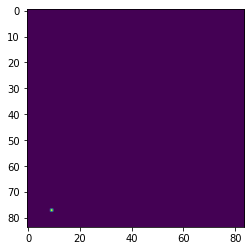

In [ ]:
#@title
#proyeccion(9)
plt.imshow(state[0])
plt.imshow(proyeccion(9))

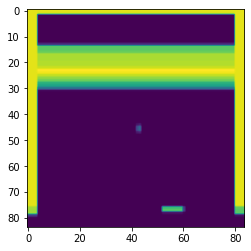

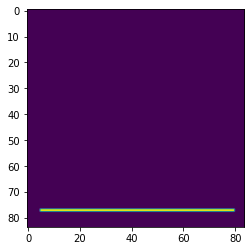

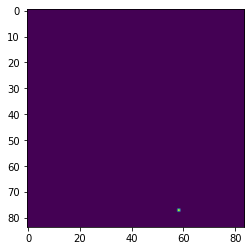

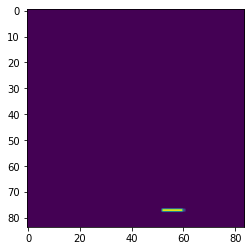

In [ ]:
#@title
#state[3]* mask_barra * proyeccion(objX)
plt.imshow(state[3])
plt.show()
plt.imshow(mask_barra)
plt.show()
plt.imshow(proyeccion(58) * state[3] * mask_barra)
plt.show()
plt.imshow(state[3] * mask_barra)
plt.show()


In [ ]:
#@title
frame_posicion(proyeccion(58) * state[3], mask_barra)

(77, 58, 1)

In [23]:
def accion_experto(state):
    # POSICION EN FRAME
    #barra, obj, bajando
    posY2, posX2, _ = frame_posicion(state[3], mask_barra) # area barra

    # POSICION OBJETIVO o PROYECTADA
    barraX, objX, ancho_barra = posicion_objetivo(state)

    #posY1, posX1, _ = frame_posicion(state[3], mask_bola) # area bola
    #posY2, posX2, _ = frame_posicion(state[3], mask_barra) # area barra
    #print(barraX, objX)

    # ACCION SEGUN POSICION EN FRAME
    acc = best_action(barraX, objX, ancho_barra)

    # EVITA MOVIMIENTOS SI YA CUBRE LA POSICION
    cubreY, cubreX, _ = frame_posicion(proyeccion(objX) * state[3], mask_barra)
    if(cubreX > 0): acc = 0
    #proyeccion(objX) * state[3] * mask_barra

    # PASA A TENSOR
    #acc = torch.max(model(states), dim=1)
    acc = torch.LongTensor([acc])
    return(acc)

#TEST MUESTRA

In [ ]:
#@title
procesa_muestra(student_model, 500 ,1)

contactos:3, tot_puntos:12, max_puntos:6


In [ ]:
#@title
procesa_muestra(expert_model, 500 , 1 )

contactos:5, tot_puntos:33, max_puntos:29


In [ ]:
#@title
def get_action_from_policy2(acc): #(model, states):
    """
    Model chooses best action for each state using learned policy.

    INPUT:
        model: torch model
        states: torch.Tensor(shape={batch_size, *(state_shape)})
    
    OUTPUT:
        torch.Tensor(shape={batch_size}) index of the best action under policy.
    """

    #_, best_action = torch.max(model(states), dim=1)
    return torch.tensor(acc) #model(states)

In [ ]:
#@title
get_action_from_policy2(2)

In [ ]:
#@title
state_tensor = torch.FloatTensor([state]).to(DEVICE)
expert_action = get_action_from_policy2(expert_model, state_tensor)

In [ ]:
#@title
expert_action

tensor([[14.8189, 15.1521, 15.6886, 14.9706]], grad_fn=<AddmmBackward0>)

*******************************


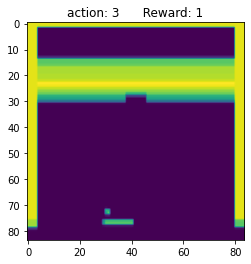

In [ ]:
#@title
  #def procesa_muestra(model, num_rollouts):
  state = env.reset()
  frames = []
  num_rollouts = 100
  pre_reward = 0

  estado_acc_previo = []
  estado_acc_ultimo = []
  acction = []
  rewards = []

  states_sample = []
  states_sample2 = []
  init=1
  game_puntos = 0
#  car = 0
#  xCar = 0
  with torch.no_grad():
      for _ in range(num_rollouts):
          # get expert action from policy
          #print("\r")
          #plt.imshow(state[0])
          #plt.title(f"action: {expert_action}      Reward: {reward}")
          #plt.show()
          state_tensor = torch.FloatTensor([state]).to(DEVICE)
          #expert_action = get_action_from_policy(expert_model, state_tensor)

          acc = accion_experto(state)
          # POSICION EN FRAME
          """posY1, posX1 = frame_posicion(state[3], mask_bola) # area bola
          posY2, posX2 = frame_posicion(state[3], mask_barra) # area barra
          """
          # ACCION SEGUN POSICION EN FRAME
          """#acc = best_acction(posX1, posX2)
          acc = 0
          if(posX2+5 < posX1): acc=2
          if(posX2 > posX1): acc=3
          if(posX1 == 0): acc=0
          expert_action = acc
          print(f'bola:{posX1} barra:{posX2} acc:{acc}')
          """


          #0 nada
          #1 fire
          #2 der
          #3 izq
          #state, reward, is_done, *(_) = env.step(int(expert_action))
          state, puntos, is_done, *(_) = env.step(acc)


          # VIDEO 8 lineas accion a partir de la secuencia de dos frames
          s1, s2 = frames_accion(state, Y=76, lineas=8)
          #states_sample.append(s2)
          #states_sample.append(dib_car(s2, car=expert_action, xPos=1, yPos=1, usemap=bot))

          # ESTADO OBSERVADO ACCIONES
          s1, s2 = frames_accion(state, Y=76, lineas=1)
          states_sample.append(s2)
          estado_acc_previo.append(s1)
          estado_acc_ultimo.append(s2)

          # ACCION
          acction.append(int(expert_action))   #np.abs(expert_action[0].numpy()))

          # VIDEO 8 lineas recompensa a partir de un frame en linea 74-76
          _, r1 = frames_accion(state, Y=70, lineas=8)
          states_sample2.append(dib_car(r1, car=expert_action, xPos=1, yPos=1, usemap=map))

          # RECOMPENSAS
          r2 = frames_reward(state, Y=73, YY=76)
          reward = r2
          rewards.append(reward)

          """
          init = init+1
          if (init==5):
            print("state")
            print(state[0])
            print("frames")
            print(frames)
            print("s1")
            print(s1)
          #plt.imshow(s1[0])
          #plt.show()
          #plt.imshow(s2)
          #plt.show()
          """

          """
          init = init+1
          if (init%10==0):
              print(state.shape)
              states_sample.append(dib_car(state[0], car=0, xPos=5, yPos=5, usemap=map))
              states_sample.append(dib_car(state[1], car=1, xPos=5, yPos=5, usemap=map))
              states_sample.append(dib_car(state[2], car=2, xPos=5, yPos=5, usemap=map))
              states_sample.append(dib_car(state[3], car=3, xPos=5, yPos=5, usemap=map))
              media.show_video(states_sample, width=300, fps=1)
          """
          # ULTIMO ESTADO OBSERVADO
          frames.append(state[3].copy())
          #frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=np.abs(expert_action[0].numpy()), xPos=5, yPos=5)
          frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=int(expert_action), xPos=5, yPos=5)

          game_puntos = game_puntos + puntos
          if(1): #puntos >0): 
            car4_puntos = int(game_puntos / 1000)
            car3_puntos = int(game_puntos - car4_puntos*1000) // 100
            car2_puntos = int(game_puntos - car3_puntos*100) // 10
            car1_puntos = int(game_puntos - car2_puntos*10)
            #print(f'{car4_puntos} {car3_puntos} {car2_puntos} {car1_puntos}')
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car4_puntos, xPos=60, yPos=5, usemap=mapnum)
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car3_puntos, xPos=65, yPos=5, usemap=mapnum)
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car2_puntos, xPos=70, yPos=5, usemap=mapnum)
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car1_puntos, xPos=75, yPos=5, usemap=mapnum)

          if(r2 >0): 
            print("\r*******************************")
            plt.imshow(state[3])
            plt.title(f"action: {int(expert_action)}      Reward: {r2}")
            plt.show()

          #print("action: ", expert_action, "     Reward: ", reward)



          if(reward + pre_reward >0): 
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=4, xPos=15, yPos=5)
          pre_reward = reward


          if is_done:
              env.reset()
              game_puntos = 0
      env.close()
      #media.resize_video(frames,  (300, 300))
      media.show_video(states_sample, width=300, fps=3)
      media.show_video(states_sample2, width=300, fps=3)
      media.show_video(frames, width=300, fps=3)

In [ ]:
#@title
r2

0

In [ ]:
#@title
  #def procesa_muestra(model, num_rollouts):
  state = env.reset()
  frames = []
  num_rollouts = 100
  pre_reward = 0
  acction = []
#  car = 0
#  xCar = 0
  frames.append(state[0].copy())
  frames.append(state[0].copy())
  frames.append(state[0].copy())
  frames.append(state[0].copy())
  with torch.no_grad():
      for _ in range(num_rollouts):
          # get expert action from policy
          #print("\r")
          #plt.imshow(state[0])
          #plt.title(f"action: {expert_action}      Reward: {reward}")
          #plt.show()
          state_tensor = torch.FloatTensor([state]).to(DEVICE)
          expert_action = get_action_from_policy(expert_model, state_tensor)
          expert_action = accion_experto(state)

          #0 nada
          #1 fire
          #2 izq
          #3 der
          state, reward, is_done, *(_) = env.step(int(expert_action))
          if(reward >0): 
            print("\r*******************************")
            plt.imshow(state[0])
            plt.title(f"action: {expert_action}      Reward: {reward}")
            plt.show()

          #print("action: ", expert_action, "     Reward: ", reward)
          frames.append(state[0].copy())
          frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=np.abs(expert_action[0].numpy()), xPos=5, yPos=5)
          acction.append(np.abs(expert_action[0].numpy()))

          if(reward + pre_reward >0): 
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=4, xPos=15, yPos=5)
          pre_reward = reward


          if is_done:
              env.reset()
      env.close()
      #media.resize_video(frames,  (300, 300))
      media.show_video(frames,width=300, fps=3)

In [ ]:
#@title
int(expert_action)

1

In [ ]:
#@title
pip install -U pygame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 36.9 MB/s eta 0:00:00


In [ ]:
#@title
import gym
import pygame
import matplotlib
import argparse
from gym import logger

try:
    matplotlib.use("TkAgg")
    import matplotlib.pyplot as plt
except ImportError as e:
    logger.warn("failed to set matplotlib backend, plotting will not work: %s" % str(e))
    plt = None

from collections import deque
from pygame.locals import VIDEORESIZE

pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
#@title
def display_arr(screen, arr, video_size, transpose):
    arr_min, arr_max = arr.min(), arr.max()
    arr = 255.0 * (arr - arr_min) / (arr_max - arr_min)
    pyg_img = pygame.surfarray.make_surface(arr.swapaxes(0, 1) if transpose else arr)
    pyg_img = pygame.transform.scale(pyg_img, video_size)
    screen.blit(pyg_img, (0, 0))

In [ ]:
#@title
def play(env, transpose=True, fps=30, zoom=None, callback=None, keys_to_action=None):
    """Allows one to play the game using keyboard.

    To simply play the game use:

        play(gym.make("Pong-v4"))

    Above code works also if env is wrapped, so it's particularly useful in
    verifying that the frame-level preprocessing does not render the game
    unplayable.

    If you wish to plot real time statistics as you play, you can use
    gym.utils.play.PlayPlot. Here's a sample code for plotting the reward
    for last 5 second of gameplay.

        def callback(obs_t, obs_tp1, action, rew, done, info):
            return [rew,]
        plotter = PlayPlot(callback, 30 * 5, ["reward"])

        env = gym.make("Pong-v4")
        play(env, callback=plotter.callback)


    Arguments
    ---------
    env: gym.Env
        Environment to use for playing.
    transpose: bool
        If True the output of observation is transposed.
        Defaults to true.
    fps: int
        Maximum number of steps of the environment to execute every second.
        Defaults to 30.
    zoom: float
        Make screen edge this many times bigger
    callback: lambda or None
        Callback if a callback is provided it will be executed after
        every step. It takes the following input:
            obs_t: observation before performing action
            obs_tp1: observation after performing action
            action: action that was executed
            rew: reward that was received
            done: whether the environment is done or not
            info: debug info
    keys_to_action: dict: tuple(int) -> int or None
        Mapping from keys pressed to action performed.
        For example if pressed 'w' and space at the same time is supposed
        to trigger action number 2 then key_to_action dict would look like this:

            {
                # ...
                sorted(ord('w'), ord(' ')) -> 2
                # ...
            }
        If None, default key_to_action mapping for that env is used, if provided.
    """
    env.reset()
    rendered = env.render(mode="rgb_array")

    if keys_to_action is None:
        if hasattr(env, "get_keys_to_action"):
            keys_to_action = env.get_keys_to_action()
        elif hasattr(env.unwrapped, "get_keys_to_action"):
            keys_to_action = env.unwrapped.get_keys_to_action()
        else:
            assert False, (
                env.spec.id
                + " does not have explicit key to action mapping, "
                + "please specify one manually"
            )
    relevant_keys = set([0,1,2,3]) #set(sum(map(list, keys_to_action.keys()), []))

    video_size = [rendered.shape[1], rendered.shape[0]]
    if zoom is not None:
        video_size = int(video_size[0] * zoom), int(video_size[1] * zoom)

    pressed_keys = []
    running = True
    env_done = True

    screen = pygame.display.set_mode(video_size)
    clock = pygame.time.Clock()

    while running:
        if env_done:
            env_done = False
            obs = env.reset()
        else:
            action = keys_to_action.get(tuple(sorted(pressed_keys)), 0)
            prev_obs = obs
            obs, rew, env_done, info = env.step(action)
            if callback is not None:
                callback(prev_obs, obs, action, rew, env_done, info)
        if obs is not None:
            rendered = env.render(mode="rgb_array")
            display_arr(screen, rendered, transpose=transpose, video_size=video_size)

        # process pygame events
        for event in pygame.event.get():
            # test events, set key states
            if event.type == pygame.KEYDOWN:
                if event.key in relevant_keys:
                    pressed_keys.append(event.key)
                elif event.key == 27:
                    running = False
            elif event.type == pygame.KEYUP:
                if event.key in relevant_keys:
                    pressed_keys.remove(event.key)
            elif event.type == pygame.QUIT:
                running = False
            elif event.type == VIDEORESIZE:
                video_size = event.size
                screen = pygame.display.set_mode(video_size)
                print(video_size)

        pygame.display.flip()
        clock.tick(fps)
    pygame.quit()


In [ ]:
#@title
play(env, zoom=4, fps=60)

In [ ]:
#@title
arr2D = numpy.array([[11, 12, 13],
                     [14, 15, 16],
                     [17, 15, 11],
                     [12, 14, 15]])


In [ ]:
#@title
acction

In [ ]:
#@title
frames[len(frames)-1][0][0:5] = [1,0,0,1,0]

array([1., 0., 0., 1., 0.], dtype=float32)

In [ ]:
#@title
# REEMPLAZA LA RED CONVOLUCIONAL
def __convolucion_manual(state):

    # datos de entrada, reemplazan la red convolucional
    Y1, X1, _ = frame_posicion(state[0], mask_bola) # area bola
    Y2, X2, _ = frame_posicion(state[3], mask_bola) # area bola
    Y3, X3, _ = frame_posicion(state[3], mask_barra) # area barra

    # objX es la X4 pero prefiero hacer el paso extra para que sea igual a los anteriores
    #barraX, objX, ancho_barra = posicion_objetivo(state)
    #Y4, X4, _ = frame_posicion(proyeccion(objX), mask_barra) # area proyeccion

    # normalizar entrada
    x1 = X1/80
    y1 = Y1/80
    x2 = X2/80
    y2 = Y2/80
    x3 = X3/80
    y3 = Y3/80
    #x4 = X4/80
    #y4 = Y4/80

    # se arma el arreglo
    arr = []
    # arr.append(x1, y1, x2, y2, x3, y3) #, y4) # sin proyeccion
    arr.append(x1)
    arr.append(y1)
    arr.append(x2)
    arr.append(y2)
    arr.append(x3)
    arr.append(y3)

    # se pasa a Tensor de 6x1 
    ##arr = torch.FloatTensor(arr)

    return arr

In [ ]:
#@title
convolucion_manual(state)

[0.825, 0.825, 0.825, 0.825, 0.7375, 0.9625]

In [ ]:
#@title
state.shape

(4, 84, 84)

#FUNCION MUESTRA

In [ ]:
#@title
objProm = 0

In [ ]:
#@title
def procesa_muestra(model, num_rollouts, expert=0):
  state = env.reset()
  frames = []
  objs = []
  global objProm 
  objProm = 0
  pasos  =0
  #num_rollouts = 100
  pre_reward = 0
  tot_reward = 0
  tot_puntos = 0
  max_puntos = 0
  game_puntos = 0
  expert_action=0
  with torch.no_grad():
      for _ in range(num_rollouts):
          # get expert action from policy
          #print("\r")
          #plt.imshow(state[0])
          #plt.title(f"action: {expert_action}      Reward: {reward}")
          #plt.show()
          if(expert==0):
            state_tensor = torch.FloatTensor([state]).to(DEVICE)
            #state_tensor = state
            coords_tensor = convolucion_manual(state)
            expert_action = get_action_from_policy(model, coords_tensor)
          else:
            expert_action = accion_experto(state) #, int(expert_action))

          state, puntos, is_done, *(_) = env.step(int(expert_action))


          # RECOMPENSAS
          reward = frames_reward(state, Y=73, YY=76)

          #if(reward >0): 
          #  print("\r*******************************")
          #  plt.imshow(state[3])
          #  plt.title(f"action: {int(expert_action)}      Reward: {reward}")
          #  plt.show()

          #print("action: ", expert_action, "     Reward: ", reward)

          #frames.append(state[3].copy())
          frames.append(env.ori.copy())
          frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=int(expert_action), xPos=5, yPos=5)
          #acction.append(np.abs(expert_action[0].numpy()))

          Yobj = 76
          _, Xobj, debajada = posicion_objetivo(state)
          if(Yobj >84-5): Yobj= 80
          if(Yobj <0): Yobj= 0
          if(Xobj >84-5): Xobj =80
          if(Xobj <0): Xobj= 0

          #if(debajada==1):
          #  pasos = pasos +1
          #  if(pasos > 5):
          #    objs.append(Xobj)
          #    objProm = sum(objs) / len(objs)
          #else:
          #  pasos = 0
          #  objs.clear()
          #  objs = [] #.clear() # prediccion posicion
          #print(len(objs))

          # la X objetivo
          frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=5, xPos=int(Xobj), yPos=int(Yobj+3), usemap=bot)

          game_puntos = game_puntos + puntos
          if(1): #puntos >0): 
            car4_puntos = int(game_puntos / 1000)
            car3_puntos = int(game_puntos - car4_puntos*1000) // 100
            car2_puntos = int(game_puntos - car3_puntos*100) // 10
            car1_puntos = int(game_puntos - car2_puntos*10)
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car4_puntos, xPos=60, yPos=5, usemap=mapnum)
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car3_puntos, xPos=65, yPos=5, usemap=mapnum)
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car2_puntos, xPos=70, yPos=5, usemap=mapnum)
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=car1_puntos, xPos=75, yPos=5, usemap=mapnum)

          if(reward + pre_reward >0): 
            frames[len(frames)-1] = dib_car(frames[len(frames)-1], car=4, xPos=15, yPos=5)
            #frames[len(frames)-1][0][0:5] = [0,0,1,0,0]
            #frames[len(frames)-1][1][0:5] = [0,0,1,0,0]
            #frames[len(frames)-1][2][0:5] = [1,1,1,1,1]
            #frames[len(frames)-1][3][0:5] = [0,0,1,0,0]
            #frames[len(frames)-1][4][0:5] = [0,0,1,0,0]
          pre_reward = reward


          tot_reward  = tot_reward + reward
          tot_puntos = tot_puntos + puntos
          if is_done:
              if(max_puntos < game_puntos) : max_puntos = game_puntos
              game_puntos = 0
              env.reset()
              #objs.clear()
              #objs = [] #.clear() # prediccion posicion
      env.close()
      if(max_puntos < game_puntos) : max_puntos = game_puntos
      #media.resize_video(frames,  (300, 300))
      #media.show_video(frames,width=300, fps=15)
      media.show_video(frames, width=320, fps=15)
      print(f"contactos:{tot_reward}, tot_puntos:{int(tot_puntos)}, max_puntos:{int(max_puntos)}")

In [24]:
def procesa_muestra(model, num_rollouts, IA=True, live=False, game=False):
  state = env.reset()
  frames = []
  tot_puntos = 0
  max_puntos = 0
  game_puntos = 0
  expert_action=0
  n_obs = 0

  if(live or game): num_rollouts = 1
  with torch.no_grad():
      for _ in range(num_rollouts):
        while(live or game):
          n_obs = n_obs + 1
          if(IA):
            state_tensor = torch.FloatTensor([state]).to(DEVICE)
            coords_tensor = convolucion_manual(state)
            expert_action = get_action_from_policy(model, coords_tensor)
          else:
            expert_action = accion_experto(state) #, int(expert_action))

          state, puntos, is_done, *(_) = env.step(int(expert_action))

          frames.append(env.ori.copy())

          game_puntos = game_puntos + puntos
          tot_puntos = tot_puntos + puntos

          if is_done:
              # Se terminan las 4 vidas, se termina el video
              if(game and env.unwrapped.ale.lives()==0): 
                game = False
                break

              # Se pierde la vida, se termina el video
              if(live): 
                live = False
                break

              if(max_puntos < game_puntos) : max_puntos = game_puntos
              game_puntos = 0
              env.reset()

      env.close()
      if(max_puntos < game_puntos) : max_puntos = game_puntos
      media.show_video(frames, width=320, fps=15)
      print(f"tot_obs:{n_obs}, tot_puntos:{int(tot_puntos)}, max_puntos:{int(max_puntos)}")

In [ ]:
#@title
procesa_muestra(expert_model, 500, 0)

contactos:0, tot_puntos:1, max_puntos:1


In [ ]:
#@title
procesa_muestra(student_model, 500, 1 )

contactos:10, tot_puntos:12, max_puntos:8


In [ ]:
#@title
sum(rewards)

SOLO OBTUVO UN PUNTO EN 100 FRAMES y este se obtiene al 4 frame del presentado en la imagen.

Sin embargo la accion que llevo a obtener el punto, ocurrio varios frames antes, por lo que, la accion evaluada no es la correcta

In [ ]:
#@title
def train_student(student_model, X, Y, optimizer, epochs=1):
    """
    Trains student model on X,Y epochs times.
    """
    dataset = torch.utils.data.TensorDataset(X, Y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    
    for epoch in (range(epochs)):
        running_loss = 0.0
        for i, (states, actions) in enumerate(dataloader, 0):

            states = states.to(DEVICE)
            expert_actions = actions.to(DEVICE)

            student_actions = student_model(states)
            loss = F.cross_entropy(student_actions, expert_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print('[%d] loss: %.6f' % (epoch + 1, running_loss / (i+1)))

In [ ]:
#@title
# behaviour cloning (imitates expert)
train_student(student_model,
              torch.cat(observations, dim=0),
              torch.stack(actions).squeeze(dim=1),
              optimizer, 5)

# DAGGER

**Solution:**

<img src="https://miro.medium.com/max/1400/1*RkCKUyRW68fAuysDgWhuMA.png">

In [ ]:
#@title
# initialize our student model with random weights
student_model = DQN(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [ ]:
#@title
optimizer = optim.Adam(student_model.parameters())

In [ ]:
##### PRIMERA EJECUCION

In [ ]:
#@title
n_ciclo = 0

In [ ]:
#@title
num_rollouts = 10000
num_rollouts = 2000
observations = []
observations.clear()
actions = []
actions.clear()
rewards = []
game_puntos_acum = []


puntos_minimo = 15

In [ ]:
#@title
# first collect expert data
num_rollouts = 1000
state = env.reset()
secuencia = []
secuencia.clear()
actions_tmp = []
actions_tmp.clear()
game_puntos =0 
puntos_minimo = 18
rewards = []
i=0
observ = []
sta =0

with torch.no_grad():
    for _ in range(num_rollouts):
        if(i%1000==0): print(f"iter:{i} ")
        i = i +1
        # get expert action from policy
        # state_tensor = torch.FloatTensor([state]) #.to(DEVICE)
        state_tensor = state
        #expert_action = get_action_from_policy(expert_model, state_tensor)
        exp_action = accion_experto(state)
        expert_action = torch.LongTensor([exp_action]) #.to(DEVICE)

        # execute **expert action**
        state, reward, is_done, *(_) = env.step(int(expert_action))
        game_puntos = game_puntos + reward

        # RECOMPENSAS
        #reward = frames_reward(state, Y=73, YY=76)

        # record state and action
        #frames.append(state[3].copy())
        #observ.append(state_tensor)
        secuencia.append(state.copy())
        actions_tmp.append(int(exp_action))
        #rewards.append(reward)

        if(reward > 0):
                game_puntos_acum.append(game_puntos)

                l_sec = len(secuencia)             # secuencia con sobrante
                i_sec = 0
                if(l_sec>45): i_sec = l_sec-45
                sta = sta + l_sec-i_sec

                sec_copy = secuencia[i_sec:].copy()        # pedazo importante de la secuencia
                #media.show_video(get_frames(sec_copy), width=300, fps=15)

                #for obs in sec_copy:                  # copiar solo 2 frames importantes pri y ult
                  #obs2_copy = []
                  #obs2_copy.append(obs[0:0].copy())
                  #obs2_copy.append(obs[3:3].copy())
                  #obs2_copy = obs[0:3:3].copy()
                  #observations.append(obs)     #obs[0:3:3].copy())  # copia el mas antiguo y nuevo del 0al3 de 2 en 2
                observations.append(sec_copy)           # se agrega nueva secuencia de N estados y 4 cuadros

                for acc in actions_tmp[i_sec:]:
                  actions.append(acc)

                print(f"i:{i}   obs:{len(observations)}   sec:{len(secuencia)}  sec_cpy:{len(sec_copy)}  sta{sta}   acc:{len(actions)}     game_puntos:{game_puntos}")

                secuencia.clear()
                actions_tmp.clear()


        if is_done:
            if(game_puntos >= puntos_minimo):
                print(f"i:{i}   obs:{len(observations)}   sec:{len(secuencia)}     sta{sta}     acc:{len(actions)}   game_puntos:{game_puntos}")
                game_puntos = 0
                secuencia.clear()
                actions_tmp.clear()
            env.reset()

    env.close()
    print(f"i:{i}  obs:{len(observations)}")

iter:0 
i:40   obs:1   sec:40  sec_cpy:40  sta40   acc:40     game_puntos:1.0
i:127   obs:2   sec:87  sec_cpy:45  sta85   acc:85     game_puntos:2.0
i:158   obs:3   sec:31  sec_cpy:31  sta116   acc:116     game_puntos:3.0
i:197   obs:4   sec:39  sec_cpy:39  sta155   acc:155     game_puntos:4.0
i:232   obs:5   sec:35  sec_cpy:35  sta190   acc:190     game_puntos:5.0
i:256   obs:6   sec:24  sec_cpy:24  sta214   acc:214     game_puntos:6.0
i:280   obs:7   sec:24  sec_cpy:24  sta238   acc:238     game_puntos:7.0
i:304   obs:8   sec:24  sec_cpy:24  sta262   acc:262     game_puntos:8.0
i:340   obs:9   sec:36  sec_cpy:36  sta298   acc:298     game_puntos:9.0
i:387   obs:10   sec:47  sec_cpy:45  sta343   acc:343     game_puntos:10.0
i:439   obs:11   sec:52  sec_cpy:45  sta388   acc:388     game_puntos:11.0
i:488   obs:12   sec:49  sec_cpy:45  sta433   acc:433     game_puntos:12.0
i:523   obs:13   sec:35  sec_cpy:35  sta468   acc:468     game_puntos:13.0
i:579   obs:14   sec:56  sec_cpy:45  sta

In [ ]:
#@title
def lanza_generador(ini=0, ciclos=1, rolls=1000):
  n_ciclo = ini

  for x in range(ciclos):
    observations = []
    observations.clear()
    actions = []
    actions.clear()

    ciclo_generador(rolls)
    grabar_datos()

In [ ]:
#@title
def ciclo_generador(rolls=1000):
 num_rollouts = 10000
 num_rollouts = rolls #1000
 global observations
 observations.clear()
 global actions
 actions.clear()
 rewards = []
 game_puntos_acum = []
 puntos_minimo = 15

 #num_rollouts = 5000
 state = env.reset()
 secuencia = []
 secuencia.clear()
 actions_tmp = []
 actions_tmp.clear()
 game_puntos =0 
 puntos_minimo = 18
 rewards = []
 i=0
 observ = []
 sta =0

 with torch.no_grad():
    for _ in range(num_rollouts):
        if(i%1000==0): print(f"iter:{i} ")
        i = i +1
        # get expert action from policy
        state_tensor = torch.FloatTensor([state]) #.to(DEVICE)
        #expert_action = get_action_from_policy(expert_model, state_tensor)
        exp_action = accion_experto(state)
        expert_action = torch.LongTensor([exp_action]) #.to(DEVICE)

        # execute **expert action**
        state, reward, is_done, *(_) = env.step(int(expert_action))
        game_puntos = game_puntos + reward

        # RECOMPENSAS
        #reward = frames_reward(state, Y=73, YY=76)

        # record state and action
        #frames.append(state[3].copy())
        #observ.append(state_tensor)
        secuencia.append(state.copy())
        actions_tmp.append(int(exp_action))
        #rewards.append(reward)

        if(reward > 0):
                game_puntos_acum.append(game_puntos)

                l_sec = len(secuencia)             # secuencia con sobrante
                i_sec = 0
                if(l_sec>45): i_sec = l_sec-45
                sta = sta + l_sec-i_sec

                sec_copy = secuencia[i_sec:].copy()        # pedazo importante de la secuencia
                #media.show_video(get_frames(sec_copy), width=300, fps=15)

                #for obs in sec_copy:                  # copiar solo 2 frames importantes pri y ult
                  #obs2_copy = []
                  #obs2_copy.append(obs[0:0].copy())
                  #obs2_copy.append(obs[3:3].copy())
                  #obs2_copy = obs[0:3:3].copy()
                  #observations.append(obs)     #obs[0:3:3].copy())  # copia el mas antiguo y nuevo del 0al3 de 2 en 2
                observations.append(sec_copy)           # se agrega nueva secuencia de N estados y 4 cuadros

                for acc in actions_tmp[i_sec:]:
                  actions.append(acc)

                print(f"i:{i}   obs:{len(observations)}   sec:{len(secuencia)}  sec_cpy:{len(sec_copy)}  sta{sta}   acc:{len(actions)}     game_puntos:{game_puntos}")

                secuencia.clear()
                actions_tmp.clear()


        if is_done:
            if(game_puntos >= puntos_minimo):
                print(f"i:{i}   obs:{len(observations)}   sec:{len(secuencia)}     sta{sta}     acc:{len(actions)}   game_puntos:{game_puntos}")
                game_puntos = 0
                secuencia.clear()
                actions_tmp.clear()
            env.reset()

    env.close()
    secuencia.clear()
    actions_tmp.clear()
    print(f"i:{i}  obs:{len(observations)}")

In [ ]:
#@title
import pickle

def grabar_datos():
  global n_ciclo
  n_ciclo = n_ciclo +1
  global observations
  global actions

  DIR_DATA = "/DATA"
  # Guardar arreglo en disco
  with open(f".{DIR_DATA}/obs_{n_ciclo}.pickle", "wb") as f:
      pickle.dump(observations, f)

  # Guardar arreglo en disco
  with open(f".{DIR_DATA}/acc_{n_ciclo}.pickle", "wb") as f:
      pickle.dump(actions, f)

In [ ]:
#@title
lanza_generador(ini=0, ciclos=1, rolls=20000)

In [ ]:
#@title
grabar_datos()

In [ ]:
#@title
#observations.append(obs_copy)  # se agrega una nueva secuencia de N estados y 4 cuadros
secuencia=2
estado=20
cuadro=3
len(observations), observations[secuencia][estado][cuadro].shape #, observations

(126, (84, 84))

In [ ]:
#@title
media.show_video(get_frames(observations[2]), width=300, fps=15)

In [ ]:
#@title
l=0
for sec in observations:
  #for sta in sec:
    l = l +len(sec)
print(len(observations) , l)

497 18003


In [ ]:
#@title
len(actions), actions[1596], int(actions[19])

(4502, 0, 3)

In [ ]:
#@title
state.shape, state.dtype, state

In [ ]:
#@title
tmp = [0,1,2,3,4,5,6,7,8,9]
tmp[3:9:2]

[3, 5, 7]

In [ ]:
#@title
observations[4][0].shape

(4, 84, 84)

In [ ]:
#@title
len(observations_tmp[0][0][0][0].shape)

0

In [ ]:
#@title
obs[0:3:2].shape

(2, 84, 84)

In [ ]:
# YA NO SE USA
def get_frames(obs_frames):
  frames = []
  for obs in obs_frames:
    frames.append(obs[0])
  return(frames)

In [ ]:
#@title
media.show_video(get_frames(observations_tmp), width=300, fps=15)

In [ ]:
#@title
observations_tmp[0]

In [ ]:
#@title
sum(rewards), sum(game_puntos_acum), len( game_puntos_acum)

(42, 400.0, 10)

In [ ]:
#@title
len(observations) , observations[0].shape, "ddd" ,  len(observations_tmp) , observations_tmp[0].shape

(3787, torch.Size([1, 4, 84, 84]), 'ddd', 28, (4, 84, 84))

In [ ]:
#@title
torch.cat(observations, dim=0).shape

torch.Size([20000, 4, 84, 84])

In [ ]:
#@title
torch.stack(actions).squeeze(dim=1).shape

torch.Size([10000])

In [ ]:
#@title
type(observations)

list

## GRABAR DATOS A ARCHIVO

In [ ]:
#@title
!rm *.pickle

In [53]:
#@title
import pickle
n_ciclo = 0  #n_ciclo +1
# Guardar arreglo en disco
with open(f"obs_{n_ciclo}.pickle", "wb") as f:
    pickle.dump(observations, f)

# Guardar arreglo en disco
with open(f"acc_{n_ciclo}.pickle", "wb") as f:
    pickle.dump(actions, f)

#CARGAR DATOS DE ARCHIVOS

In [25]:
#@title
import pickle
n_ciclo = 0
DIR_DATA = "" #"/DATA"
# Recuperar arreglo desde disco
with open(f".{DIR_DATA}/obs_{n_ciclo}.pickle", "rb") as f:
    observations = pickle.load(f)

with open(f".{DIR_DATA}/acc_{n_ciclo}.pickle", "rb") as f:
    actions = pickle.load(f)
#print(arr_recovered)

In [ ]:
#@title
 obsTensors = [] 
 for secuencia in( observations):
   for estado in( secuencia):
      obsTensors.append( torch.FloatTensor([estado]) )
 #observations.clear()
 len(obsTensors), obsTensors[0].shape

(18003, torch.Size([1, 4, 84, 84]))

In [ ]:
#@title
 accTensors = [] 
 for acc in( actions):
   #for estado in( secuencia):
   accTensors.append( torch.LongTensor([acc]) )
 #actions.clear()
 len(accTensors), accTensors[0].shape

(18003, torch.Size([1]))

In [ ]:
#@title
# behaviour cloning (imitates expert)
train_student(student_model,
              torch.cat(obsTensors[:], dim=0),
              torch.stack(accTensors).squeeze(dim=1),
              optimizer, 5)

[1] loss: 0.008128
[2] loss: 0.007813
[3] loss: 0.008747
[4] loss: 0.009072
[5] loss: 0.005323


In [ ]:
#@title
procesa_muestra(student_model, 500)

contactos:0, tot_puntos:5, max_puntos:1


In [ ]:
#@title
procesa_muestra(expert_model, 500)

contactos:12, tot_puntos:11, max_puntos:5


In [ ]:
#@title
procesa_muestra(student_model, 500, 1)

contactos:5, tot_puntos:16, max_puntos:12


# TRAINING STUDENT

In [26]:
# initialize our student model with random weights
student_model = DQN(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [27]:
optimizer = optim.Adam(student_model.parameters() ) #, lr=0.001, weight_decay=0.0001)

In [ ]:
#loss_fn = nn.CrossEntropyLoss()

In [28]:
import copy

def train_student(student_model, X, Y, optimizer, epochs=1):
    """
    Trains student model on X,Y epochs times.
    """
    dataset = torch.utils.data.TensorDataset(X, Y)   #64 BATCH
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)  # shuffle=True
    prev = None # {}

    for epoch in (range(epochs)):
        running_loss = 0.0
        # prev = student_model.state_dict().clone()     # .copy() sigue enlazada
        prev = copy.deepcopy(student_model.state_dict())

        for i, (states, actions) in enumerate(dataloader, 0):

            states = states.to(DEVICE)
            expert_actions = actions.to(DEVICE)

            student_actions = student_model(states)
            loss = F.cross_entropy(student_actions, expert_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        #changeW = student_model.state_dict()['fc1.weight'] - prev['fc1.weight']
        #changeB = student_model.state_dict()['fc1.bias'] - prev['fc1.bias']
        #change_norm = torch.norm(change, p=2)

        print('[%d] loss: %.6f' % (epoch + 1, running_loss / (i+1)))

        # IMPRIME DIFERENCIAS EN AJUSTES
        #for param_tensor in student_model.state_dict():
          # diff = student_model.state_dict() - prev
          #print(param_tensor, ": ", student_model.state_dict()[param_tensor] - prev[param_tensor])
          #print(student_model.state_dict()[param_tensor])
        #print("\n")

    # IMPRIME RESULTADO DE W y BIAS
    for param_tensor in student_model.state_dict():
      # diff = student_model.state_dict() - prev
      print(param_tensor, ": ", student_model.state_dict()[param_tensor])


In [ ]:
#@title
state = env.reset()
coords_tensor = convolucion_manual(state)
coords_tensor

tensor([[0.5500, 0.8500, 0.5500, 0.8500, 0.3500, 0.9625]])

In [ ]:
#@title
expert_action = student_model(coords_tensor)
expert_action

tensor([[ 0.0547, -0.3743,  0.3051, -0.0786]], grad_fn=<AddmmBackward0>)

In [ ]:
#@title
len(observations)


0

In [ ]:
#@title
####### TEST DATA SET


import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# Let's create 10 RGB images of size 128x128 and 10 labels {0, 1}
data = list(np.random.randint(0, 255, size=(10, 3, 128, 128)))
targets = list(np.random.randint(2, size=(10)))

transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
dataset = MyDataset(data, targets, transform=transform)
dataloader = DataLoader(dataset, batch_size=5)


In [ ]:
#@title
# behaviour cloning (imitates expert)
train_student(student_model,
              torch.cat(observations[:], dim=0),
              torch.stack(actions).squeeze(dim=1),
              optimizer, 5)

In [ ]:
#@title
torch.stack(accTensors).squeeze(dim=1)

tensor([[3, 3, 3,  ..., 3, 0, 2]])

In [ ]:
#@title
len(accTensors[0])

1

In [ ]:
#@title
len(observations)

126

In [ ]:
#@title
len(observations[0]), observations[0]

In [ ]:
#@title
 secuencia = 0
 estado = 0
 state_tensor = torch.FloatTensor(observations[secuencia][estado])
 len(state_tensor)

4

In [ ]:
#@title
len(obsTensors), obsTensors[0].shape

(4565, torch.Size([1, 4, 84, 84]))

In [ ]:
#@title
len(accTensors), accTensors[0].shape

(4565, torch.Size([1]))

In [ ]:
#@title
accTensors[0]

tensor([3])

In [ ]:
#@title
actions

In [ ]:
#@title
 for secuencias in ( observations):
   for estados in( secuencias):
      print(len(estados), len(secuencias))

In [ ]:
#@title
len(observations[0][0])

In [ ]:
#@title
len(state_tensor)

4

## PREPARA SET DE DATOS DEL ENTRENADOR

In [27]:
observations = []
actions = []
frames = []

In [39]:
# init data with EXPERT
state = env.reset()
num_rollouts = 5000
#num_rollouts = 500
rewards = []
obs = []  # inicia
act = []  # inicia

with torch.no_grad():
    for _ in range(num_rollouts):
        # NO get BOTH student and expert action from policy
        coords_tensor = convolucion_manual(state)
        #expert_action = get_action_from_policy(model, coords_tensor)

        state_tensor = torch.FloatTensor([state]).to(DEVICE)
        #state_tensor = state
        #student_action = get_action_from_policy(student_model, state_tensor)
        #expert_action = get_action_from_policy(expert_model, state_tensor)
        expert_action = accion_experto(state)
        expert_action = torch.LongTensor([expert_action]).to(DEVICE)

        # execute **EXPERT action**
        state, reward, is_done, *(_) = env.step(int(expert_action))


        # execute **STUDENT action**
        #state, reward, is_done, *(_) = env.step(int(student_action))

        # RECOMPENSAS
        #reward = frames_reward(state, Y=73, YY=76)


        obs.append(coords_tensor)
        act.append(expert_action)

        if(reward > 0): # debe copiar ultimos 45 estados y acciones
          # record state and EXPERT action
          if(len(obs) < 45):  # copia todos
            observations = observations + obs
            actions = actions + act
          else: # copia solo los ultimos 45
            observations = observations + obs[-45:]
            actions = actions + act[-45:]
            #observations.append(obs[-45:])
            #actions.append(act[-45:])
          obs = []
          act = []


        # record state and EXPERT action
        #frames.append(state_tensor)
        #observations.append(coords_tensor)
        #actions.append(expert_action)
        rewards.append(reward)

        if is_done:
            obs = []  # reinicia
            act = []  # reinicia
            env.reset()

    env.close()

In [40]:
sum(rewards)

139.0

In [41]:
len(observations), len(frames), len(actions)

(12225, 0, 12225)

In [ ]:
observations[0].shape    ,actions[0].shape  #,frames[0].shape 

(torch.Size([1, 6]), torch.Size([1]))

In [233]:
observations[499]

tensor([[0.3375, 0.4125, 0.2875, 0.5250, 0.3125, 0.9625]])

In [234]:
actions[499]

tensor([3])

In [ ]:
#@title
frames[499]

In [ ]:
#@title
observations[0][0].shape

torch.Size([6])

In [ ]:
#@title
torch.cat(observations, dim=1)

In [ ]:
#@title
torch.cat(observations, dim=0), torch.cat(observations, dim=0).shape, torch.cat(observations, dim=0).size()

In [ ]:
#@title
torch.stack(actions).squeeze(dim=1), torch.stack(actions).squeeze(dim=1).shape

(tensor([3, 3, 3,  ..., 3, 3, 3]), torch.Size([5000]))

In [ ]:
#@title
OBS = torch.cat(observations, dim=0)
#OBS = observations[0]
ACC = torch.stack(actions).squeeze(dim=1)

dataset = torch.utils.data.TensorDataset(OBS,  ACC)
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)    

In [ ]:
#@title
observations[4][0].size()

torch.Size([6])

## ENTRENAMIENTO DEL ALUMNO 

In [81]:
train_student(student_model,
              torch.cat(observations, dim=0),
              torch.stack(actions).squeeze(dim=1),
              optimizer, 10)

[1] loss: 0.687171
[2] loss: 0.686879
[3] loss: 0.686669
[4] loss: 0.686388
[5] loss: 0.686324
[6] loss: 0.685969
[7] loss: 0.685848
[8] loss: 0.685611
[9] loss: 0.685334
[10] loss: 0.685293
fc1.weight :  tensor([[ -0.8829,   1.1931,   1.4393,   1.3166,  -0.3823,  -0.5452],
        [ -1.7343,  -2.3765,  -1.6828,  -1.6401,  -2.9847,  -9.1378],
        [ -4.6680,   0.1991,  11.1593,  -1.8842,  -7.4419,   1.1158],
        [  6.7386,  -0.8355, -14.4695,   1.6727,   8.7052,   0.3485]])
fc1.bias :  tensor([-0.1952, -9.3406,  1.6000, -0.2978])


In [45]:
#@title
student_model.state_dict()['fc1.weight']

tensor([[-1.0503e-03,  3.2842e-01, -4.8215e-01,  3.0128e-01,  1.2242e-01,
          1.7160e-01],
        [-9.3703e-01, -1.1034e+00, -8.9631e-01, -3.7636e-01, -5.2860e-01,
         -5.8893e-01],
        [ 9.9099e-03,  1.5476e-01,  1.0063e+00,  9.7023e-02, -3.8813e-01,
          2.8066e-02],
        [ 6.3512e-01,  6.6819e-02, -8.6425e-01,  2.4306e-01,  7.1593e-01,
          6.1299e-01]])

In [ ]:
#@title
prev = student_model.state_dict().copy()


In [ ]:
#@title
student_model.state_dict()['fc1.weight'] - prev['fc1.weight']

tensor([[ 1.6636e-01, -1.2453e+00,  2.2544e+00,  1.4389e+00, -1.5226e+00,
         -5.3382e-01],
        [ 1.9349e+00,  2.3331e+00,  1.3651e+00,  2.2142e+00,  3.1111e+00,
          7.6019e+00],
        [ 6.4904e+00, -1.8858e+00, -9.5621e+00,  1.7761e+00,  4.8539e+00,
          1.0812e-01],
        [-5.6289e+00,  4.1634e+00,  9.1906e+00, -4.3897e+00, -2.7405e+00,
         -7.8530e-03]])

In [ ]:
#@title
prev

OrderedDict([('fc1.weight',
              tensor([[ 7.1186e-03,  2.0869e+00, -2.7561e+00, -2.0033e+00,  2.1060e+00,
                        1.1088e+00],
                      [-2.5094e+00, -3.5452e+00, -2.2832e+00, -3.4028e+00, -4.0335e+00,
                       -8.2904e+00],
                      [-6.7766e+00,  2.3974e+00,  1.1404e+01, -1.3896e+00, -5.2830e+00,
                        9.0928e-03],
                      [ 6.9084e+00, -4.2900e+00, -1.0184e+01,  5.0338e+00,  3.5412e+00,
                        1.5265e-01]])),
             ('fc1.bias', tensor([ 0.5578, -8.5243,  0.3485,  0.4130]))])

In [ ]:
#@title
print(student_model.state_dict()['fc1.weight'])
print(prev['fc1.weight'])

tensor([[ 0.0731,  1.1072, -1.1516, -0.7719,  0.9755,  0.5385],
        [-1.4578, -1.9923, -1.0116, -2.0971, -2.2266, -2.2715],
        [-1.3569,  0.3234,  3.7947,  0.6963, -1.9833, -0.1999],
        [ 2.0078, -0.6958, -2.8980,  1.4201,  1.6052,  0.0247]])
tensor([[  0.0312,   2.1060,  -2.7794,  -1.9722,   2.1430,   1.0905],
        [ -2.5108,  -3.5503,  -2.2861,  -3.4088,  -4.0480,  -8.3630],
        [ -6.8138,   2.4323,  11.4555,  -1.4397,  -5.2816,   0.0472],
        [  6.9224,  -4.3393, -10.2022,   5.0359,   3.5064,   0.1468]])


In [ ]:
#@title
print(student_model.state_dict()['fc1.bias'])
print(prev['fc1.bias'])

tensor([ 0.4721, -1.8698,  0.3440,  0.3574])
tensor([ 0.5395, -8.5997,  0.3867,  0.4072])


In [ ]:
#@title
student_model.state_dict()['fc1.bias'] - prev['fc1.bias']

tensor([-0.0674,  6.7299, -0.0427, -0.0498])

## AUMENTACION DE DATOS EVALUANDO AL ALUMNO

In [78]:
# augment data with student
state = env.reset()

rewards = []
with torch.no_grad():
    for _ in range(num_rollouts):
        # get BOTH student and expert action from policy

        #state_tensor = torch.FloatTensor([state]).to(DEVICE)
        #student_action = get_action_from_policy(student_model, state_tensor)
        coords_tensor = convolucion_manual(state)
        student_action = get_action_from_policy(student_model, coords_tensor)

        ##expert_action = get_action_from_policy(expert_model, state_tensor)
        expert_action = accion_experto(state)
        expert_action = torch.LongTensor([expert_action]).to(DEVICE)

        # execute STUDENT action
        state, reward, is_done, *(_) = env.step(int(student_action))

        # RECOMPENSAS
        #reward = frames_reward(state, Y=73, YY=76)

        # record state and EXPERT action
        observations.append(coords_tensor)
        actions.append(expert_action)
        rewards.append(reward)

        if is_done:
            env.reset()

    env.close()

In [79]:
sum(rewards)

119.0

In [ ]:
#@title
 coords_tensor


tensor([[0.4750, 0.8500, 0.4750, 0.8500, 0.2375, 0.9625]])

In [ ]:
#@title
get_action_from_policy(student_model, coords_tensor)

tensor([0, 0, 0, 0])

In [82]:
len(rewards), len(actions), len(observations)

(5000, 42225, 42225)

In [83]:
train_student(student_model,
              torch.cat(observations, dim=0),
              torch.stack(actions).squeeze(dim=1),
              optimizer, 2)

[1] loss: 0.685064
[2] loss: 0.684825
fc1.weight :  tensor([[ -0.8929,   1.2272,   1.4602,   1.2860,  -0.3858,  -0.5430],
        [ -1.7345,  -2.3772,  -1.6830,  -1.6408,  -2.9864,  -9.1561],
        [ -4.6806,   0.2003,  11.2137,  -1.8734,  -7.4714,   1.1273],
        [  6.7639,  -0.8817, -14.5618,   1.6985,   8.7419,   0.3324]])
fc1.bias :  tensor([-0.1931, -9.3596,  1.6115, -0.3138])


In [ ]:
#@title
# augment data with student
state = env.reset()

rewards = []
with torch.no_grad():
    for _ in range(num_rollouts):
        # get BOTH student and expert action from policy

        #state_tensor = torch.FloatTensor([state]).to(DEVICE)
        #student_action = get_action_from_policy(student_model, state_tensor)
        coords_tensor = convolucion_manual(state)
        student_action = get_action_from_policy(student_model, coords_tensor)

        #expert_action = get_action_from_policy(expert_model, state_tensor)
        expert_action = accion_experto(state)
        expert_action = torch.LongTensor([expert_action]).to(DEVICE)

        # execute STUDENT action
        state, reward, is_done, *(_) = env.step(int(student_action))

        # RECOMPENSAS
        #reward = frames_reward(state, Y=73, YY=76)

        # record state and EXPERT action
        observations.append(coords_tensor)
        actions.append(expert_action)
        rewards.append(reward)

        if is_done:
            env.reset()
    env.close()

In [ ]:
#@title
len(rewards), len(actions), len(observations)

(5000, 15000, 15000)

In [ ]:
#@title
sum(rewards)

96.0

## ALUMNO

In [131]:
procesa_muestra(student_model, 500, game=True)

tot_obs:565, tot_puntos:18, max_puntos:8


In [ ]:
#@title
procesa_muestra(expert_model, 500)

contactos:0, tot_puntos:0, max_puntos:0


## ENTRENADOR

In [36]:
procesa_muestra(student_model, 500, IA=False, game=True) #live=True

tot_obs:1330, tot_puntos:72, max_puntos:21


In [38]:
procesa_muestra(expert_model, 500, IA=True, game=True) #live=True

tot_obs:1353, tot_puntos:56, max_puntos:30


In [ ]:
#@title
procesa_muestra(expert_model, 10000)

273 446.0


In [ ]:
#@title
procesa_muestra(student_model, 10000)

160 331.0


A diferencia del modelo Experto, el Estudiante logro obtener 3 puntos en 100 pasos

## ANALISIS DE PESOS Y BIAS

In [ ]:
for param_tensor in student_model.state_dict():
    print(param_tensor, "\t", student_model.state_dict()[param_tensor].size())


fc1.weight 	 torch.Size([4, 6])
fc1.bias 	 torch.Size([4])


In [87]:
for param_tensor in student_model.state_dict():
    print(param_tensor, "\t", student_model.state_dict()[param_tensor])


fc1.weight 	 tensor([[ -0.8929,   1.2272,   1.4602,   1.2860,  -0.3858,  -0.5430],
        [ -1.7345,  -2.3772,  -1.6830,  -1.6408,  -2.9864,  -9.1561],
        [ -4.6806,   0.2003,  11.2137,  -1.8734,  -7.4714,   1.1273],
        [  6.7639,  -0.8817, -14.5618,   1.6985,   8.7419,   0.3324]])
fc1.bias 	 tensor([-0.1931, -9.3596,  1.6115, -0.3138])


In [ ]:
student_model

DQN(
  (fc1): Linear(in_features=6, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=4, bias=True)
)

In [ ]:
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name], "\n")

state 	 {0: {'step': tensor(32970.), 'exp_avg': tensor([[ 6.9189e-03,  5.4275e-03,  4.4424e-03,  6.0029e-03,  2.2503e-03,
          6.6222e-03],
        [ 1.4572e-10,  4.1970e-10,  1.6423e-10,  4.5767e-10,  6.7633e-10,
          3.0411e-09],
        [ 1.4468e-03,  4.5737e-03, -3.4680e-03,  7.3585e-03,  2.1331e-03,
          6.1558e-03],
        [-8.3657e-03, -1.0001e-02, -9.7443e-04, -1.3361e-02, -4.3834e-03,
         -1.2778e-02]]), 'exp_avg_sq': tensor([[1.0322e-03, 1.5611e-03, 9.2357e-04, 1.5780e-03, 9.6349e-04, 3.0635e-03],
        [6.1997e-18, 1.3579e-17, 5.9097e-18, 1.2931e-17, 1.0427e-17, 1.2783e-16],
        [5.9170e-04, 9.5422e-04, 6.8648e-04, 9.9787e-04, 5.5358e-04, 1.8699e-03],
        [8.3093e-04, 1.0854e-03, 6.5006e-04, 1.0738e-03, 7.8320e-04, 2.3271e-03]])}, 1: {'step': tensor(32970.), 'exp_avg': tensor([ 6.8802e-03,  3.1596e-09,  6.3957e-03, -1.3276e-02]), 'exp_avg_sq': tensor([3.3069e-03, 1.3799e-16, 2.0184e-03, 2.5119e-03])}} 

param_groups 	 [{'lr': 0.001, 'betas': (0

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

# Homework

1. [1.5 puntos] Indica una **ventaja** de usar Dagger comparado con sólo entrenar imitando al experto (*behaviour cloning*).
**RESPUESTA:** la aumentacion de datos para el entrenamiento acelera el proceso de aprendizaje al contar con un set mas grande, ademas de que las decisiones diferentes incorporadas pueden aportar a nuevas y mejores decisiones, aun que el fin es alcanzar o igualar al experto

2. [1.5 puntos] Indica una **desventaja** de usar Dagger comparado con sólo entrenar imitando al experto (*behaviour cloning*).
**RESPUESTA:** el hecho de iterar el proceso de experiencia en el juego y de aprendizaje del modelo, va aumentando el set de entrenamiento y esto puede tomar mas y mas tiempo

3. [1 punto] ¿Por qué la salida del experto son números reales?
**RESPUESTA:** porque entregara la accion con mayor recompenza, una de las tres acciones: boton Izq, boton Der, boton Fire, al pasar por la funcion get_action_from_policy()

4. [1 punto] ¿Por qué la salida del estudiante son probabilidades?
**RESPUESTA:** porque el estudiante entrega todas las acciones con sus probabilidades de cual es la mejor segun el experto

5. [1 punto] ¿Cómo se maneja la discrepancia entre la salida del experto y el estudiante al usar Dagger?
**RESPUESTA:** la diferencia corresponde al Loss entre la mejor opcion de ambos (experto/estudiante), pero se deja la accion del experto con la recompenza obtenida por la accion del estudiante, esto sirve para aumentar la cantidad de ejemplos 


6. Como observacion extra, el juego solo da recompensas al romper un bloque, pero la accion del agente que llevo a ese punto, ocurrio varios pasos antes, por lo que, es util para evitar morir, pero no necesariamente para ganar el juego.


# Deep Dive: Limitations

Main advantage is that it's faster at learning compared to typical reinforcement learning approaches as supervision is less sparse (each action results in training signal).

However, the resulting model:
- is limited to the performance of the teacher
- doesn't generalize to situations out of the training set

## Case Study: Starcraft AI SOTA

<img src="https://lh3.googleusercontent.com/ckm-3GlBQJ4zbNzfiW97yPqj5PVC0qIbRg42FL35EbDkhWoCNxyNZMMJN-f6VZmLMRbyBk2PArLQ-jDxlHbsE3_YaDUmcxUvMf8M=w1440">

Action space is enormous and rewards are sparse, so pretraining with imitation learning is used:

> The neural network was initially trained by supervised learning from anonymised human games released by Blizzard. This allowed AlphaStar to learn, by imitation, the basic micro and macro-strategies used by players on the StarCraft ladder.

After this pretraining step reinforcement learning is used to further train the models to **superhuman** performance.



In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
!ls drive/My*/DINTA/TareaAtari/DATA
!cp *.pickle   drive/My*/DINTA/TareaAtari/DATA/

In [ ]:
#@title
! du    drive/My*/DINTA/TareaAtari/DATA/

15428777	drive/MyDrive/DINTA/TareaAtari/DATA/


In [ ]:
#@title
!cp drive/My*/DINTA/TareaAtari/DATA/* ./DATA

In [ ]:
#@title
!rm drive/My*/DINTA/TareaAtari/DATA/*
!ls drive/My*/DINTA/TareaAtari/DATA

rm: cannot remove 'drive/My*/DINTA/TareaAtari/DATA/*': No such file or directory
